In [2]:
import sys
sys.path.append('../data_cleaning/lem_stem_functions')
from text_functions_new_vocabs_ac import new_column_lemmatizer, new_column_stemmatizer, new_count_vectorize_data, new_tfidf_vectorize_data

import pandas as pd
import numpy as np
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


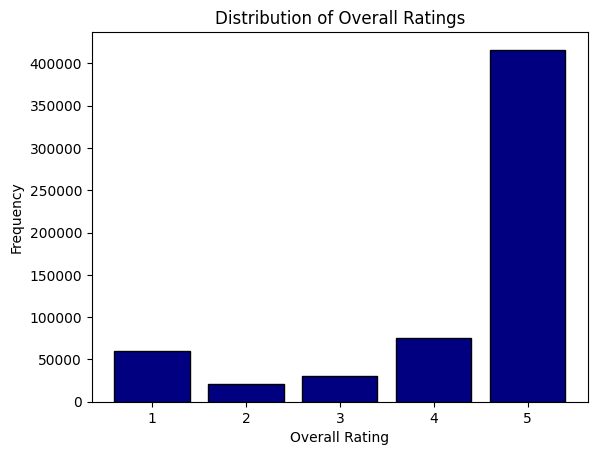

0

In [3]:
# Load the given dataset
df = pd.read_json("../../../data/raw/Appliances.json", lines = True)
df.head()

# initial preprocessing

# Fill missing values in 'style,' 'reviewerName,' 'reviewText,' and 'summary' with empty strings
columns_to_fill = ['style', 'reviewerName', 'reviewText', 'summary']
df[columns_to_fill] = df[columns_to_fill].astype(str)
df[columns_to_fill] = df[columns_to_fill].replace('', np.nan)
df = df.dropna(subset='reviewText')

# Convert 'vote' to numeric (assuming 'NaN' means 0)
df['vote'] = df['vote'].str.replace(',', '', regex=True).fillna(0).astype(int)

# Convert reviewTime
df['reviewTime'] = pd.to_datetime(df['reviewTime'], format = '%m %d, %Y')

# Delete the 'image' column
df.drop('image', axis=1, inplace=True)

# Histogram for overall ratings
plt.hist(df['overall'], bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5], color = 'navy', edgecolor = 'black', rwidth = 0.8)
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Overall Ratings')
plt.xticks(range(1, 6))
plt.show()

df['reviewText'].isna().sum()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602777 entries, 0 to 602776
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   overall         602777 non-null  int64         
 1   vote            602777 non-null  int32         
 2   verified        602777 non-null  bool          
 3   reviewTime      602777 non-null  datetime64[ns]
 4   reviewerID      602777 non-null  object        
 5   asin            602777 non-null  object        
 6   style           602777 non-null  object        
 7   reviewerName    602777 non-null  object        
 8   reviewText      602777 non-null  object        
 9   summary         602777 non-null  object        
 10  unixReviewTime  602777 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int32(1), int64(2), object(6)
memory usage: 44.3+ MB


In [4]:
# df = df.sample(5000)

In [5]:
# # Histogram for overall ratings
# plt.hist(df['overall'], bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5], color = 'navy', edgecolor = 'black', rwidth = 0.8)
# plt.xlabel('Overall Rating')
# plt.ylabel('Frequency')
# plt.title('Distribution of Overall Ratings')
# plt.xticks(range(1, 6))
# plt.show()

In [6]:
y = df['overall']
X = df.drop(columns='overall')

In [7]:
# Split the data into training and testing sets
X_train_nosample, X_test, y_train_nosample, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
# Undersampling
undersampler = RandomUnderSampler(sampling_strategy='auto')
X_train, y_train = undersampler.fit_resample(X_train_nosample, y_train_nosample)

X_train_nosample = X_train_nosample['reviewText']
X_test = X_test['reviewText']

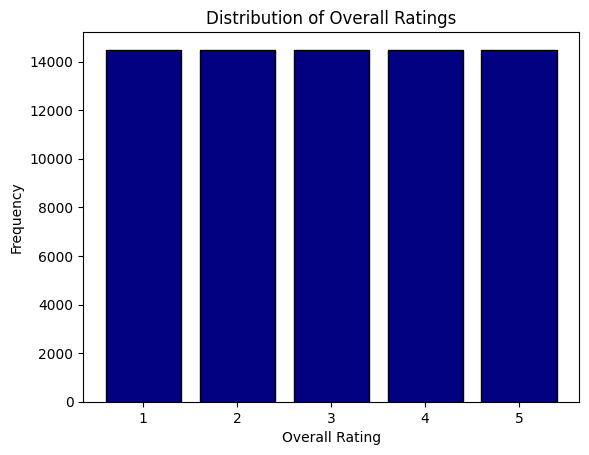

In [9]:
# Histogram for overall ratings
plt.hist(y_train, bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5], color = 'navy', edgecolor = 'black', rwidth = 0.8)
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Overall Ratings')
plt.xticks(range(1, 6))
plt.show()

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72445 entries, 544571 to 546312
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   vote            72445 non-null  int32         
 1   verified        72445 non-null  bool          
 2   reviewTime      72445 non-null  datetime64[ns]
 3   reviewerID      72445 non-null  object        
 4   asin            72445 non-null  object        
 5   style           72445 non-null  object        
 6   reviewerName    72445 non-null  object        
 7   reviewText      72445 non-null  object        
 8   summary         72445 non-null  object        
 9   unixReviewTime  72445 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int32(1), int64(1), object(6)
memory usage: 5.3+ MB


In [11]:
"""
With two methods of tokenizing ands 2 methods of vectorizing the text fields, that gives us 4 potential cobinations to test the regression.
To test the regression we can use the LinearRegression model to check for a linear regression and we can use the crossvalidation to verify
any detected linear relationships.

First though we must identify and preprocess our 4 types of data

This cell could take a few minutes to run.
"""

# Lemmatized data
X_lem_train = new_column_lemmatizer(X_train['reviewText'])
X_lem_test = new_column_lemmatizer(X_test['reviewText'])

# Stemmatized data
X_stem_train = new_column_stemmatizer(X_train['reviewText'])
X_stem_test = new_column_stemmatizer(X_test['reviewText'])

# Lemmatized CountVectorized data
X_lem_CV_train, X_lem_CV_test = new_count_vectorize_data(X_lem_train, X_lem_test)

# Lemmatized TFIDFVectorized data
X_lem_RFID_train, X_lem_RFID_test = new_tfidf_vectorize_data(X_lem_train, X_lem_test)

# Stemmatized CountVectorized data
X_stem_CV_train, X_stem_CV_test = new_count_vectorize_data(X_stem_train, X_stem_test)

# Stemmatized TFIDFVectorized data
X_stem_RFID_train, X_stem_RFID_test = new_tfidf_vectorize_data(X_stem_train, X_stem_test)

X_test = X_test['reviewText']

# # Dense arrays
# X_lem_CV_train_dense = X_lem_CV_train.toarray()
# X_lem_CV_test_dense = X_lem_CV_test.toarray()
# X_lem_RFID_train_dense = X_lem_RFID_train.toarray()
# X_lem_RFID_test_dense = X_lem_RFID_test.toarray()
# X_stem_CV_train_dense = X_stem_CV_train.toarray()
# X_stem_CV_test_dense = X_stem_CV_test.toarray()
# X_stem_RFID_train_dense = X_stem_RFID_train.toarray()
# X_stem_RFID_test_dense = X_stem_RFID_test.toarray()

FileNotFoundError: [Errno 2] No such file or directory: './notebooks/full_vocab_list.csv'

# 1. Logistic Regression


In [12]:
# a) Lemmatized CountVectorized data

logistic_model = LogisticRegression(solver='saga')
logistic_model.fit(X_lem_CV_train, y_train)
y_pred_train_logistic_lem_cv = logistic_model.predict(X_lem_CV_train)
y_pred_test_logistic_lem_cv = logistic_model.predict(X_lem_CV_test)
# logistic_report_lem_cv = classification_report(y_test, y_pred_logistic_lem_cv)
logistic_report_train_lem_cv_imbalanced = classification_report_imbalanced(y_train, y_pred_train_logistic_lem_cv)
logistic_report_test_lem_cv_imbalanced = classification_report_imbalanced(y_test, y_pred_test_logistic_lem_cv)
# confusion_matrix_logistic_lem_cv = confusion_matrix(y_test, y_pred_logistic_lem_cv)
accuracy_train_logistic_lem_cv = accuracy_score(y_train, y_pred_train_logistic_lem_cv)
accuracy_test_logistic_lem_cv = accuracy_score(y_test, y_pred_test_logistic_lem_cv)
# print("Logistic Regression Classification Report (lem_cv):", logistic_report_lem_cv)
print("Logistic Regression - Classification Report: Train Data (lem_cv) - imbalanced:\n", logistic_report_train_lem_cv_imbalanced)
print("\nLogistic Regression - Classification Report: Test Data (lem_cv) - imbalanced:\n", logistic_report_test_lem_cv_imbalanced)
# print("\nConfusion Matrix (lem_cv):")
# display(confusion_matrix_logistic_lem_cv)
print("\nAccuracy Score: Train Data (lem_cv):", accuracy_train_logistic_lem_cv)
print("Accuracy Score: Test Data (lem_cv):", accuracy_test_logistic_lem_cv)



c:\Users\Scratticus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression - Classification Report: Train Data (lem_cv) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.55      0.65      0.87      0.59      0.75      0.55     14489
          2       0.43      0.35      0.88      0.38      0.56      0.29     14489
          3       0.45      0.35      0.89      0.40      0.56      0.30     14489
          4       0.43      0.42      0.86      0.42      0.60      0.35     14489
          5       0.56      0.68      0.86      0.61      0.77      0.58     14489

avg / total       0.48      0.49      0.87      0.48      0.65      0.41     72445


Logistic Regression - Classification Report: Test Data (lem_cv) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.51      0.63      0.93      0.57      0.77      0.57     17758
          2       0.14      0.31      0.93      0.19      0.54      0.27      6245
      

In [13]:
# b) Lemmatized TFIDFVectorized data

logistic_model = LogisticRegression(solver='saga')
logistic_model.fit(X_lem_RFID_train, y_train)
y_pred_train_logistic_lem_rfid = logistic_model.predict(X_lem_RFID_train)
y_pred_test_logistic_lem_rfid = logistic_model.predict(X_lem_RFID_test)
# logistic_report_lem_cv = classification_report(y_test, y_pred_logistic_lem_cv)
logistic_report_train_lem_rfid_imbalanced = classification_report_imbalanced(y_train, y_pred_train_logistic_lem_rfid)
logistic_report_test_lem_rfid_imbalanced = classification_report_imbalanced(y_test, y_pred_test_logistic_lem_rfid)
# confusion_matrix_logistic_lem_cv = confusion_matrix(y_test, y_pred_logistic_lem_cv)
accuracy_train_logistic_lem_rfid = accuracy_score(y_train, y_pred_train_logistic_lem_rfid)
accuracy_test_logistic_lem_rfid = accuracy_score(y_test, y_pred_test_logistic_lem_rfid)
# print("Logistic Regression Classification Report (lem_cv):", logistic_report_lem_cv)
print("Logistic Regression - Classification Report: Train Data (lem_tfidf) - imbalanced:\n", logistic_report_train_lem_rfid_imbalanced)
print("\nLogistic Regression - Classification Report: Test Data (lem_tfidf) - imbalanced:\n", logistic_report_test_lem_rfid_imbalanced)
# print("\nConfusion Matrix (lem_cv):")
# display(confusion_matrix_logistic_lem_cv)
print("\nAccuracy Score: Train Data (lem_tfidf):", accuracy_train_logistic_lem_rfid)
print("Accuracy Score: Test Data (lem_tfidf):", accuracy_test_logistic_lem_rfid)

Logistic Regression - Classification Report: Train Data (lem_tfidf) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.65      0.72      0.90      0.68      0.81      0.64     14489
          2       0.55      0.53      0.89      0.54      0.69      0.46     14489
          3       0.55      0.53      0.89      0.54      0.69      0.46     14489
          4       0.56      0.51      0.90      0.53      0.68      0.44     14489
          5       0.67      0.72      0.91      0.69      0.81      0.64     14489

avg / total       0.60      0.60      0.90      0.60      0.73      0.53     72445


Logistic Regression - Classification Report: Test Data (lem_tfidf) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.58      0.63      0.95      0.60      0.77      0.58     17758
          2       0.15      0.38      0.93      0.22      0.59      0.33      6245


In [14]:
# c) Stemmatized CountVectorized data

logistic_model = LogisticRegression(solver='saga')
logistic_model.fit(X_stem_CV_train, y_train)
y_pred_train_logistic_stem_cv = logistic_model.predict(X_stem_CV_train)
y_pred_test_logistic_stem_cv = logistic_model.predict(X_stem_CV_test)
# logistic_report_lem_cv = classification_report(y_test, y_pred_logistic_lem_cv)
logistic_report_train_stem_cv_imbalanced = classification_report_imbalanced(y_train, y_pred_train_logistic_stem_cv)
logistic_report_test_stem_cv_imbalanced = classification_report_imbalanced(y_test, y_pred_test_logistic_stem_cv)
# confusion_matrix_logistic_lem_cv = confusion_matrix(y_test, y_pred_logistic_lem_cv)
accuracy_train_logistic_stem_cv = accuracy_score(y_train, y_pred_train_logistic_stem_cv)
accuracy_test_logistic_stem_cv = accuracy_score(y_test, y_pred_test_logistic_stem_cv)
# print("Logistic Regression Classification Report (lem_cv):", logistic_report_lem_cv)
print("Logistic Regression - Classification Report: Train Data (stem_cv) - imbalanced:\n", logistic_report_train_stem_cv_imbalanced)
print("\nLogistic Regression - Classification Report: Test Data (stem_cv) - imbalanced:\n", logistic_report_test_stem_cv_imbalanced)
# print("\nConfusion Matrix (lem_cv):")
# display(confusion_matrix_logistic_lem_cv)
print("\nAccuracy Score: Train Data (stem_cv):", accuracy_train_logistic_stem_cv)
print("Accuracy Score: Test Data (stem_cv):", accuracy_test_logistic_stem_cv)

c:\Users\Scratticus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression - Classification Report: Train Data (stem_cv) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.55      0.64      0.87      0.59      0.75      0.55     14489
          2       0.42      0.35      0.88      0.38      0.55      0.29     14489
          3       0.44      0.35      0.89      0.39      0.56      0.30     14489
          4       0.43      0.44      0.85      0.43      0.61      0.36     14489
          5       0.56      0.67      0.87      0.61      0.76      0.57     14489

avg / total       0.48      0.49      0.87      0.48      0.65      0.41     72445


Logistic Regression - Classification Report: Test Data (stem_cv) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.52      0.63      0.94      0.57      0.77      0.57     17758
          2       0.14      0.31      0.93      0.20      0.54      0.27      6245
    

In [15]:
# d) Stemmatized TFIDFVectorized data

logistic_model = LogisticRegression(solver='saga')
logistic_model.fit(X_stem_RFID_train, y_train)
y_pred_train_logistic_stem_rfid = logistic_model.predict(X_stem_RFID_train)
y_pred_test_logistic_stem_rfid = logistic_model.predict(X_stem_RFID_test)
# logistic_report_lem_cv = classification_report(y_test, y_pred_logistic_lem_cv)
logistic_report_train_stem_rfid_imbalanced = classification_report_imbalanced(y_train, y_pred_train_logistic_stem_rfid)
logistic_report_test_stem_rfid_imbalanced = classification_report_imbalanced(y_test, y_pred_test_logistic_stem_rfid)
# confusion_matrix_logistic_lem_cv = confusion_matrix(y_test, y_pred_logistic_lem_cv)
accuracy_train_logistic_stem_rfid = accuracy_score(y_train, y_pred_train_logistic_stem_rfid)
accuracy_test_logistic_stem_rfid = accuracy_score(y_test, y_pred_test_logistic_stem_rfid)
# print("Logistic Regression Classification Report (lem_cv):", logistic_report_lem_cv)
print("Logistic Regression - Classification Report: Train Data (stem_tfidf) - imbalanced:\n", logistic_report_train_stem_rfid_imbalanced)
print("\nLogistic Regression - Classification Report: Test Data (stem_tfidf) - imbalanced:\n", logistic_report_test_stem_rfid_imbalanced)
# print("\nConfusion Matrix (lem_cv):")
# display(confusion_matrix_logistic_lem_cv)
print("\nAccuracy Score: Train Data (stem_tfidf):", accuracy_train_logistic_stem_rfid)
print("Accuracy Score: Test Data (stem_tfidf):", accuracy_test_logistic_stem_rfid)

Logistic Regression - Classification Report: Train Data (stem_tfidf) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.63      0.70      0.90      0.67      0.79      0.62     14489
          2       0.52      0.50      0.89      0.51      0.67      0.43     14489
          3       0.53      0.50      0.89      0.51      0.67      0.43     14489
          4       0.54      0.49      0.90      0.51      0.66      0.42     14489
          5       0.66      0.71      0.91      0.68      0.80      0.63     14489

avg / total       0.58      0.58      0.90      0.58      0.72      0.51     72445


Logistic Regression - Classification Report: Test Data (stem_tfidf) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.57      0.63      0.95      0.60      0.77      0.57     17758
          2       0.15      0.37      0.92      0.21      0.58      0.32      624

## Summary - Logistic Regression

In [16]:
# a) Lemmatized CountVectorized data
logistic_report_train_lem_cv_imbalanced_last = [accuracy_train_logistic_lem_cv*100] + [float(value) for value in logistic_report_train_lem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
logistic_report_test_lem_cv_imbalanced_last = [accuracy_test_logistic_lem_cv*100] + [float(value) for value in logistic_report_test_lem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_logistic_report_lem_cv_imbalanced = pd.DataFrame([logistic_report_train_lem_cv_imbalanced_last, logistic_report_test_lem_cv_imbalanced_last], columns=column_names)
final_logistic_report_lem_cv_imbalanced['Data Type'] = ['Lemmatized Count Vectorized', 'Lemmatized Count Vectorized']
final_logistic_report_lem_cv_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_logistic_report_lem_cv_imbalanced.set_index('Data Type', inplace=True)
final_logistic_report_lem_cv_imbalanced.index.name = None

# Reorder columns
final_logistic_report_lem_cv_imbalanced = final_logistic_report_lem_cv_imbalanced[['Train/Test'] + column_names]


# b) Lemmatized TFIDFVectorized data
logistic_report_train_lem_rfid_imbalanced_last = [accuracy_train_logistic_lem_rfid*100] + [float(value) for value in logistic_report_train_lem_rfid_imbalanced.split()[-7:]] # Extracting the last 6 values
logistic_report_test_lem_rfid_imbalanced_last = [accuracy_test_logistic_lem_rfid*100] + [float(value) for value in logistic_report_test_lem_rfid_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_logistic_report_lem_rfid_imbalanced = pd.DataFrame([logistic_report_train_lem_rfid_imbalanced_last, logistic_report_test_lem_rfid_imbalanced_last], columns=column_names)
final_logistic_report_lem_rfid_imbalanced['Data Type'] = ['Lemmatized TFIDF Vectorized', 'Lemmatized TFIDF Vectorized']
final_logistic_report_lem_rfid_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_logistic_report_lem_rfid_imbalanced.set_index('Data Type', inplace=True)
final_logistic_report_lem_rfid_imbalanced.index.name = None

# Reorder columns
final_logistic_report_lem_rfid_imbalanced = final_logistic_report_lem_rfid_imbalanced[['Train/Test'] + column_names]


# c) Stemmatized CountVectorized data
logistic_report_train_stem_cv_imbalanced_last = [accuracy_train_logistic_stem_cv*100] + [float(value) for value in logistic_report_train_stem_cv_imbalanced.split()[-7:]] # Extracting the last 6 values
logistic_report_test_stem_cv_imbalanced_last = [accuracy_test_logistic_stem_cv*100] + [float(value) for value in logistic_report_test_stem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_logistic_report_stem_cv_imbalanced = pd.DataFrame([logistic_report_train_stem_cv_imbalanced_last, logistic_report_test_stem_cv_imbalanced_last], columns=column_names)
final_logistic_report_stem_cv_imbalanced['Data Type'] = ['Stemmatized Count Vectorized', 'Stemmatized Count Vectorized']
final_logistic_report_stem_cv_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_logistic_report_stem_cv_imbalanced.set_index('Data Type', inplace=True)
final_logistic_report_stem_cv_imbalanced.index.name = None

# Reorder columns
final_logistic_report_stem_cv_imbalanced = final_logistic_report_stem_cv_imbalanced[['Train/Test'] + column_names]


# d) Stemmatized TFIDFVectorized data
logistic_report_train_stem_rfid_imbalanced_last = [accuracy_train_logistic_stem_rfid*100]+ [float(value) for value in logistic_report_train_stem_rfid_imbalanced.split()[-7:]] # Extracting the last 6 values
logistic_report_test_stem_rfid_imbalanced_last = [accuracy_test_logistic_stem_rfid*100] + [float(value) for value in logistic_report_test_stem_rfid_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_logistic_report_stem_rfid_imbalanced = pd.DataFrame([logistic_report_train_stem_rfid_imbalanced_last, logistic_report_test_stem_rfid_imbalanced_last], columns=column_names)
final_logistic_report_stem_rfid_imbalanced['Data Type'] = ['Stemmatized TFIDF Vectorized', 'Stemmatized TFIDF Vectorized']
final_logistic_report_stem_rfid_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_logistic_report_stem_rfid_imbalanced.set_index('Data Type', inplace=True)
final_logistic_report_stem_rfid_imbalanced.index.name = None

# Reorder columns
final_logistic_report_stem_rfid_imbalanced = final_logistic_report_stem_rfid_imbalanced[['Train/Test'] + column_names]


### Averaged classification report for Logistic Regression

In [17]:
final_logistic_report = pd.concat([final_logistic_report_lem_cv_imbalanced,
                    final_logistic_report_lem_rfid_imbalanced,
                    final_logistic_report_stem_cv_imbalanced,
                    final_logistic_report_stem_rfid_imbalanced])

final_logistic_report.head(8)

,Train/Test,Accuracy,Precision,Recall,Specificity,F1-Score,Geometric Mean,Index Balanced Accuracy (IBA),Support
Lemmatized Count Vectorized,Train,49.053765,0.48,0.49,0.87,0.48,0.65,0.41,72445.0
Lemmatized Count Vectorized,Test,60.162912,0.72,0.60,0.85,0.64,0.71,0.50,180834.0
Lemmatized TFIDF Vectorized,Train,60.197391,0.60,0.60,0.90,0.60,0.73,0.53,72445.0
Lemmatized TFIDF Vectorized,Test,59.659135,0.73,0.60,0.87,0.64,0.72,0.51,180834.0
Stemmatized Count Vectorized,Train,48.919870,0.48,0.49,0.87,0.48,0.65,0.41,72445.0
Stemmatized Count Vectorized,Test,59.637015,0.72,0.60,0.85,0.64,0.71,0.49,180834.0
Stemmatized TFIDF Vectorized,Train,58.135137,0.58,0.58,0.90,0.58,0.72,0.51,72445.0
Stemmatized TFIDF Vectorized,Test,59.256556,0.73,0.59,0.87,0.64,0.71,0.50,180834.0


### Confusion Matrix for Logistic Regression

[[11247  3455  1282   930   844]
 [ 1961  1959  1177   701   447]
 [ 1209  1730  3030  2240  1061]
 [ 1228  1607  3259  9116  7309]
 [ 6322  5126  5885 24266 83443]]
[[11130  4164  1453   570   441]
 [ 1876  2345  1370   428   226]
 [ 1072  2065  3782  1737   614]
 [  978  1770  4392  9023  6356]
 [ 4224  4921  8207 26086 81604]]
[[11211  3453  1326   964   804]
 [ 1967  1956  1179   711   432]
 [ 1173  1740  3091  2222  1044]
 [ 1149  1604  3325  9382  7059]
 [ 6001  4986  5927 25924 82204]]
[[11102  4152  1419   598   487]
 [ 1871  2298  1372   459   245]
 [ 1091  2106  3717  1716   640]
 [ 1038  1851  4328  8960  6342]
 [ 4443  5054  8283 26183 81079]]


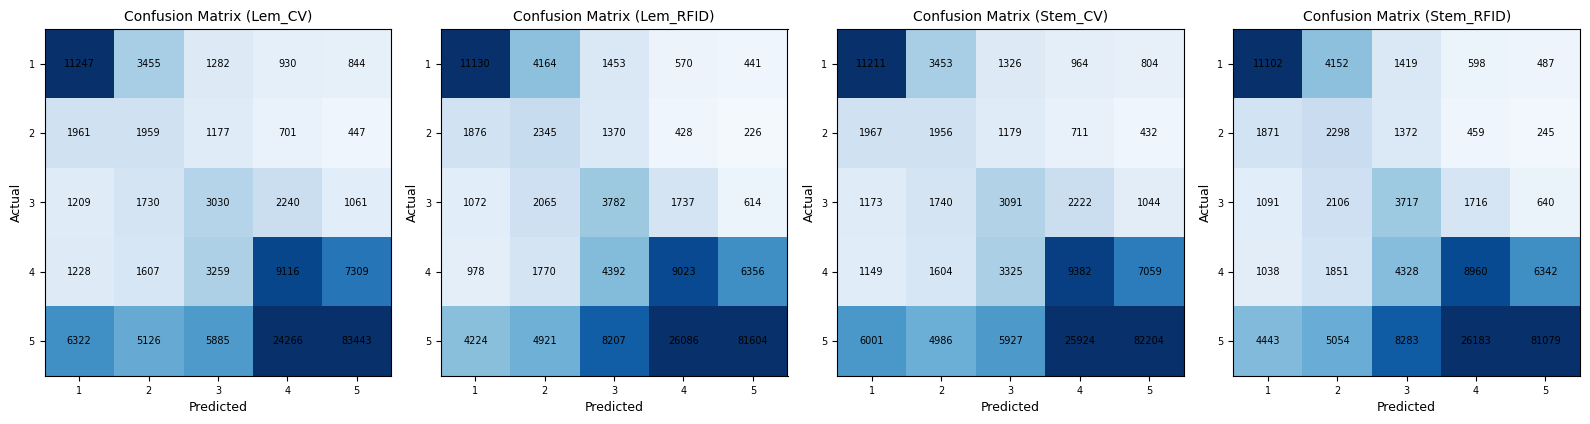

Lem_TFIDF: Train Accuracy - 0.6020, Test Accuracy - 0.5966
Stem_TFIDF: Train Accuracy - 0.5814, Test Accuracy - 0.5926
Lem_CV: Train Accuracy - 0.4905, Test Accuracy - 0.6016
Stem_CV: Train Accuracy - 0.4892, Test Accuracy - 0.5964


In [105]:
combinations = ['Lem_CV', 'Lem_RFID', 'Stem_CV', 'Stem_RFID']

plt.figure(figsize=(16, 4))

for i, combination in enumerate(combinations, 1):
    plt.subplot(1, 4, i)
    
    # Get y_test and y_pred_test for the current combination
    y_test_comb = globals()[f"y_test"]
    y_pred_test_comb = globals()[f"y_pred_test_logistic_{combination.lower()}"]
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test_comb, y_pred_test_comb)

    print(cm)
    
    # Plotting Confusion Matrix using imshow
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 10000)
    
    # Adding annotations
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)
    
    plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
    plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
    plt.title(f'Confusion Matrix ({combination})', fontsize=10)
    plt.xlabel('Predicted', fontsize=9)
    plt.ylabel('Actual', fontsize=9)

plt.tight_layout()
# plt.savefig('../../images/LRUSConfMatrix.png')
plt.show()

accuracy_scores = {
    'Lem_CV': {'Train': accuracy_train_logistic_lem_cv, 'Test': accuracy_test_logistic_lem_cv},
    'Lem_TFIDF': {'Train': accuracy_train_logistic_lem_rfid, 'Test': accuracy_test_logistic_lem_rfid},
    'Stem_CV': {'Train': accuracy_train_logistic_stem_cv, 'Test': accuracy_test_logistic_stem_cv},
    'Stem_TFIDF': {'Train': accuracy_train_logistic_stem_rfid, 'Test': accuracy_test_logistic_stem_rfid},
}

# Sorting based on the test accuracy
sorted_accuracy_scores = sorted(accuracy_scores.items(), key=lambda x: x[1]['Train'], reverse=True)

# Displaying the sorted results
for combination, scores in sorted_accuracy_scores:
    print(f"{combination}: Train Accuracy - {scores['Train']:.4f}, Test Accuracy - {scores['Test']:.4f}")

### Best Logistic Model

In [11]:
# Best Logistic regression Model

# Best results achieved without Sampling
best_logistic_train_tokens = new_column_lemmatizer(X_train_nosample)
print('train lemmatized')
best_logistic_test_tokens = new_column_lemmatizer(X_test)
print('test lemmatized')

best_logistic_train_vectors, best_logistic_test_vectors = new_tfidf_vectorize_data(best_logistic_train_tokens, best_logistic_test_tokens)
print('data vectorized')
# best_logistic_train_sampled = 

# all data is relationally the same whether scaled or not
# scaler = MaxAbsScaler()
# best_logistic_train_scaled = scaler.fit_transform(best_logistic_train_vectors)
# best_logistic_test_scaled = scaler.transform(best_logistic_test_vectors)

print('preprocessing complete')

best_logistic_model = LogisticRegression(solver='saga', C=100, l1_ratio=0.3, penalty="elasticnet")
best_logistic_model.fit(best_logistic_train_vectors, y_train_nosample)

print('model fitted')

y_pred_train_logistic_best = best_logistic_model.predict(best_logistic_train_vectors)
print('train predicted')

y_pred_test_logistic_best = best_logistic_model.predict(best_logistic_test_vectors)
print('test predicted')

accuracy_train_logistic_best = accuracy_score(y_train_nosample, y_pred_train_logistic_best)
precision_train_logistic_best = precision_score(y_train_nosample, y_pred_train_logistic_best, average='weighted')
recall_train_logistic_best = recall_score(y_train_nosample, y_pred_train_logistic_best, average='weighted')
f1_train_logistic_best = f1_score(y_train_nosample, y_pred_train_logistic_best, average='weighted')
r2_train_logistic_best = r2_score(y_train_nosample, y_pred_train_logistic_best)
mse_train_logistic_best = mean_squared_error(y_train_nosample, y_pred_train_logistic_best)

accuracy_test_logistic_best = accuracy_score(y_test, y_pred_test_logistic_best)
precision_test_logistic_best = precision_score(y_test, y_pred_test_logistic_best, average='weighted')
recall_test_logistic_best = recall_score(y_test, y_pred_test_logistic_best, average='weighted')
f1_test_logistic_best = f1_score(y_test, y_pred_test_logistic_best, average='weighted')
r2_test_logistic_best = r2_score(y_test, y_pred_test_logistic_best)
mse_test_logistic_best = mean_squared_error(y_test, y_pred_test_logistic_best)

print('Train Results')
print("Accuracy Score: Logistic Regression Train Data (lem - TFIDF):", accuracy_train_logistic_best)
print("Precision Score: Logistic Regression Train Data (lem - TFIDF):", precision_train_logistic_best)
print("Recall Score: Logistic Regression Train Data (lem - TFIDF):", recall_train_logistic_best)
print("F1 Score: Logistic Regression Train Data (lem - TFIDF):", f1_train_logistic_best)
print("R Squared Score: Logistic Regression Train Data (lem - TFIDF):", r2_train_logistic_best)
print("Mean Squared Error Score: Logistic Regression Train Data (lem - TFIDF):", mse_train_logistic_best)
print()
print('Test Results')
print("Accuracy Score: Logistic Regression Test Data (lem - TFIDF):", accuracy_test_logistic_best)
print("Precision Score: Logistic Regression Test Data (lem - TFIDF):", precision_test_logistic_best)
print("Recall Score: Logistic Regression Test Data (lem - TFIDF):", recall_test_logistic_best)
print("F1 Score: Logistic Regression Test Data (lem - TFIDF):", f1_test_logistic_best)
print("R Squared Score: Logistic Regression Test Data (lem - TFIDF):", r2_test_logistic_best)
print("Mean Squared Error Score: Logistic Regression Test Data (lem - TFIDF):", mse_test_logistic_best)


train lemmatized
test lemmatized
data vectorized
preprocessing complete


c:\Users\Scratticus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


model fitted
train predicted
test predicted
Train Results
Accuracy Score: Logistic Regression Train Data (lem - TFIDF): 0.7997644231566823
Precision Score: Logistic Regression Train Data (lem - TFIDF): 0.7743440105541728
Recall Score: Logistic Regression Train Data (lem - TFIDF): 0.7997644231566823
F1 Score: Logistic Regression Train Data (lem - TFIDF): 0.7670295563181965
R Squared Score: Logistic Regression Train Data (lem - TFIDF): 0.5370714643975757
Mean Squared Error Score: Logistic Regression Train Data (lem - TFIDF): 0.7854496934420052

Test Results
Accuracy Score: Logistic Regression Test Data (lem - TFIDF): 0.7491788048707655
Precision Score: Logistic Regression Test Data (lem - TFIDF): 0.6924180066158961
Recall Score: Logistic Regression Test Data (lem - TFIDF): 0.7491788048707655
F1 Score: Logistic Regression Test Data (lem - TFIDF): 0.7082387832537097
R Squared Score: Logistic Regression Test Data (lem - TFIDF): 0.3841061336837175
Mean Squared Error Score: Logistic Regressio

In [12]:
with open('../../../models/classification/LogisticBestModel.pkl', 'wb') as file:
    pickle.dump(best_logistic_model, file)

print('model fitted')

model fitted


In [26]:
# Calculate confusion matrix
plt.figure(figsize=(8, 4))

# Calculate confusion matrix
cm = confusion_matrix(y_train_nosample, y_pred_train_logistic_best)

print(cm)

# Plotting Confusion Matrix using imshow
plt.subplot(1, 2, 1)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 30000)

# Adding annotations
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)

plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.xlabel('Predicted', fontsize=9)
plt.ylabel('Actual', fontsize=9)
plt.title(f'Confusion Matrix Logistic Regression Train Data', fontsize=10)

cm = confusion_matrix(y_test, y_pred_test_logistic_best)

print(cm)
plt.subplot(1, 2, 2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 30000)

# Adding annotations
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)

plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.xlabel('Predicted', fontsize=9)
plt.ylabel('Actual', fontsize=9)

plt.title(f'Confusion Matrix Logistic Regression Test Data', fontsize=10)
plt.tight_layout()
# plt.savefig('../../images/logisticBestConfMatrix.png')
plt.show()

NameError: name 'y_pred_train_logistic_best' is not defined

<Figure size 800x400 with 0 Axes>

# 2. Support Vector Machine (SVM)

In [19]:
# a) Lemmatized CountVectorized data

# SVM model
svm_model = SVC()
svm_model.fit(X_lem_CV_train, y_train)
y_pred_train_svm_lem_cv = svm_model.predict(X_lem_CV_train)
y_pred_test_svm_lem_cv = svm_model.predict(X_lem_CV_test)

# SVM classification reports and accuracy scores
svm_report_train_lem_cv_imbalanced = classification_report_imbalanced(y_train, y_pred_train_svm_lem_cv)
svm_report_test_lem_cv_imbalanced = classification_report_imbalanced(y_test, y_pred_test_svm_lem_cv)
accuracy_train_svm_lem_cv = accuracy_score(y_train, y_pred_train_svm_lem_cv)
accuracy_test_svm_lem_cv = accuracy_score(y_test, y_pred_test_svm_lem_cv)

# Print results
print("SVM - Classification Report: Train Data (lem_cv) - imbalanced:\n", svm_report_train_lem_cv_imbalanced)
print("\nSVM - Classification Report: Test Data (lem_cv) - imbalanced:\n", svm_report_test_lem_cv_imbalanced)
print("\nAccuracy Score: Train Data (lem_cv):", accuracy_train_svm_lem_cv)
print("Accuracy Score: Test Data (lem_cv):", accuracy_test_svm_lem_cv)

SVM - Classification Report: Train Data (lem_cv) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.74      0.79      0.93      0.76      0.86      0.72     14489
          2       0.70      0.66      0.93      0.68      0.78      0.60     14489
          3       0.68      0.63      0.92      0.65      0.76      0.57     14489
          4       0.62      0.59      0.91      0.60      0.73      0.52     14489
          5       0.69      0.75      0.91      0.72      0.83      0.67     14489

avg / total       0.68      0.68      0.92      0.68      0.79      0.62     72445


SVM - Classification Report: Test Data (lem_cv) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.59      0.60      0.95      0.60      0.76      0.55     17758
          2       0.13      0.42      0.90      0.19      0.61      0.36      6245
          3       0.20      0.38      

In [20]:
# b) Lemmatized TFIDFVectorized data

# SVM model
svm_model = SVC()
svm_model.fit(X_lem_RFID_train, y_train)
y_pred_train_svm_lem_rfid = svm_model.predict(X_lem_RFID_train)
y_pred_test_svm_lem_rfid = svm_model.predict(X_lem_RFID_test)

# SVM classification reports and accuracy scores
svm_report_train_lem_rfid_imbalanced = classification_report_imbalanced(y_train, y_pred_train_svm_lem_rfid)
svm_report_test_lem_rfid_imbalanced = classification_report_imbalanced(y_test, y_pred_test_svm_lem_rfid)
accuracy_train_svm_lem_rfid = accuracy_score(y_train, y_pred_train_svm_lem_rfid)
accuracy_test_svm_lem_rfid = accuracy_score(y_test, y_pred_test_svm_lem_rfid)

# Print results
print("SVM - Classification Report: Train Data (lem_tfidf) - imbalanced:\n", svm_report_train_lem_rfid_imbalanced)
print("\nSVM - Classification Report: Test Data (lem_tfidf) - imbalanced:\n", svm_report_test_lem_rfid_imbalanced)
print("\nAccuracy Score: Train Data (lem_tfidf):", accuracy_train_svm_lem_rfid)
print("Accuracy Score: Test Data (lem_tfidf):", accuracy_test_svm_lem_rfid)

SVM - Classification Report: Train Data (lem_tfidf) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.86      0.90      0.96      0.88      0.93      0.87     14489
          2       0.86      0.86      0.97      0.86      0.91      0.82     14489
          3       0.86      0.82      0.97      0.84      0.89      0.78     14489
          4       0.81      0.77      0.96      0.79      0.86      0.72     14489
          5       0.82      0.86      0.95      0.84      0.91      0.81     14489

avg / total       0.84      0.84      0.96      0.84      0.90      0.80     72445


SVM - Classification Report: Test Data (lem_tfidf) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.60      0.63      0.95      0.61      0.77      0.58     17758
          2       0.15      0.40      0.92      0.22      0.61      0.35      6245
          3       0.20      0.44

In [ ]:
# c) Stemmatized CountVectorized data

# SVM model
svm_model = SVC()
svm_model.fit(X_stem_CV_train, y_train)
y_pred_train_svm_stem_cv = svm_model.predict(X_stem_CV_train)
y_pred_test_svm_stem_cv = svm_model.predict(X_stem_CV_test)

# SVM classification reports and accuracy scores
svm_report_train_stem_cv_imbalanced = classification_report_imbalanced(y_train, y_pred_train_svm_stem_cv)
svm_report_test_stem_cv_imbalanced = classification_report_imbalanced(y_test, y_pred_test_svm_stem_cv)
accuracy_train_svm_stem_cv = accuracy_score(y_train, y_pred_train_svm_stem_cv)
accuracy_test_svm_stem_cv = accuracy_score(y_test, y_pred_test_svm_stem_cv)

# Print results
print("SVM - Classification Report: Train Data (stem_cv) - imbalanced:\n", svm_report_train_stem_cv_imbalanced)
print("\nSVM - Classification Report: Test Data (stem_cv) - imbalanced:\n", svm_report_test_stem_cv_imbalanced)
print("\nAccuracy Score: Train Data (stem_cv):", accuracy_train_svm_stem_cv)
print("Accuracy Score: Test Data (stem_cv):", accuracy_test_svm_stem_cv)

SVM - Classification Report: Train Data (stem_cv) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.73      0.78      0.93      0.75      0.85      0.71     14489
          2       0.68      0.65      0.92      0.66      0.77      0.58     14489
          3       0.67      0.61      0.92      0.64      0.75      0.55     14489
          4       0.60      0.58      0.90      0.59      0.73      0.51     14489
          5       0.68      0.74      0.91      0.71      0.82      0.66     14489

avg / total       0.67      0.67      0.92      0.67      0.78      0.60     72445


SVM - Classification Report: Test Data (stem_cv) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.59      0.60      0.95      0.59      0.76      0.55     17758
          2       0.13      0.42      0.89      0.19      0.62      0.36      6245
          3       0.20      0.37    

In [22]:
# d) Stemmatized TFIDFVectorized data

# SVM model
svm_model = SVC()
svm_model.fit(X_stem_RFID_train, y_train)
y_pred_train_svm_stem_rfid = svm_model.predict(X_stem_RFID_train)
y_pred_test_svm_stem_rfid = svm_model.predict(X_stem_RFID_test)

# SVM classification reports and accuracy scores
svm_report_train_stem_rfid_imbalanced = classification_report_imbalanced(y_train, y_pred_train_svm_stem_rfid)
svm_report_test_stem_rfid_imbalanced = classification_report_imbalanced(y_test, y_pred_test_svm_stem_rfid)
accuracy_train_svm_stem_rfid = accuracy_score(y_train, y_pred_train_svm_stem_rfid)
accuracy_test_svm_stem_rfid = accuracy_score(y_test, y_pred_test_svm_stem_rfid)

# Print results
print("SVM - Classification Report: Train Data (stem_tfidf) - imbalanced:\n", svm_report_train_stem_rfid_imbalanced)
print("\nSVM - Classification Report: Test Data (stem_tfidf) - imbalanced:\n", svm_report_test_stem_rfid_imbalanced)
print("\nAccuracy Score: Train Data (stem_tfidf):", accuracy_train_svm_stem_rfid)
print("Accuracy Score: Test Data (stem_tfidf):", accuracy_test_svm_stem_rfid)


SVM - Classification Report: Train Data (stem_tfidf) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.85      0.89      0.96      0.87      0.92      0.85     14489
          2       0.84      0.85      0.96      0.84      0.90      0.80     14489
          3       0.84      0.80      0.96      0.82      0.88      0.76     14489
          4       0.80      0.75      0.95      0.77      0.85      0.70     14489
          5       0.81      0.85      0.95      0.83      0.90      0.80     14489

avg / total       0.83      0.83      0.96      0.83      0.89      0.78     72445


SVM - Classification Report: Test Data (stem_tfidf) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.60      0.63      0.95      0.61      0.77      0.58     17758
          2       0.15      0.41      0.92      0.22      0.61      0.36      6245
          3       0.20      0.

## Summary - Support Vector Machine

In [23]:
# a) Lemmatized CountVectorized data
svm_report_train_lem_cv_imbalanced_last = [accuracy_train_svm_lem_cv*100] + [float(value) for value in svm_report_train_lem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
svm_report_test_lem_cv_imbalanced_last = [accuracy_test_svm_lem_cv*100] + [float(value) for value in svm_report_test_lem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_svm_report_lem_cv_imbalanced = pd.DataFrame([svm_report_train_lem_cv_imbalanced_last, svm_report_test_lem_cv_imbalanced_last], columns=column_names)
final_svm_report_lem_cv_imbalanced['Data Type'] = ['Lemmatized Count Vectorized', 'Lemmatized Count Vectorized']
final_svm_report_lem_cv_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_svm_report_lem_cv_imbalanced.set_index('Data Type', inplace=True)
final_svm_report_lem_cv_imbalanced.index.name = None

# Reorder columns
final_svm_report_lem_cv_imbalanced = final_svm_report_lem_cv_imbalanced[['Train/Test'] + column_names]


# b) Lemmatized TFIDFVectorized data
svm_report_train_lem_rfid_imbalanced_last = [accuracy_train_svm_lem_rfid*100] + [float(value) for value in svm_report_train_lem_rfid_imbalanced.split()[-7:]] # Extracting the last 6 values
svm_report_test_lem_rfid_imbalanced_last = [accuracy_test_svm_lem_rfid*100] + [float(value) for value in svm_report_test_lem_rfid_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_svm_report_lem_rfid_imbalanced = pd.DataFrame([svm_report_train_lem_rfid_imbalanced_last, svm_report_test_lem_rfid_imbalanced_last], columns=column_names)
final_svm_report_lem_rfid_imbalanced['Data Type'] = ['Lemmatized TFIDF Vectorized', 'Lemmatized TFIDF Vectorized']
final_svm_report_lem_rfid_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_svm_report_lem_rfid_imbalanced.set_index('Data Type', inplace=True)
final_svm_report_lem_rfid_imbalanced.index.name = None

# Reorder columns
final_svm_report_lem_rfid_imbalanced = final_svm_report_lem_rfid_imbalanced[['Train/Test'] + column_names]


# c) Stemmatized CountVectorized data
svm_report_train_stem_cv_imbalanced_last = [accuracy_train_svm_stem_cv*100] + [float(value) for value in svm_report_train_stem_cv_imbalanced.split()[-7:]] # Extracting the last 6 values
svm_report_test_stem_cv_imbalanced_last = [accuracy_test_svm_stem_cv*100] + [float(value) for value in svm_report_test_stem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_svm_report_stem_cv_imbalanced = pd.DataFrame([svm_report_train_stem_cv_imbalanced_last, svm_report_test_stem_cv_imbalanced_last], columns=column_names)
final_svm_report_stem_cv_imbalanced['Data Type'] = ['Stemmatized Count Vectorized', 'Stemmatized Count Vectorized']
final_svm_report_stem_cv_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_svm_report_stem_cv_imbalanced.set_index('Data Type', inplace=True)
final_svm_report_stem_cv_imbalanced.index.name = None

# Reorder columns
final_svm_report_stem_cv_imbalanced = final_svm_report_stem_cv_imbalanced[['Train/Test'] + column_names]


# d) Stemmatized TFIDFVectorized data
svm_report_train_stem_rfid_imbalanced_last = [accuracy_train_svm_stem_rfid*100]+ [float(value) for value in svm_report_train_stem_rfid_imbalanced.split()[-7:]] # Extracting the last 6 values
svm_report_test_stem_rfid_imbalanced_last = [accuracy_test_svm_stem_rfid*100] + [float(value) for value in svm_report_test_stem_rfid_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_svm_report_stem_rfid_imbalanced = pd.DataFrame([svm_report_train_stem_rfid_imbalanced_last, svm_report_test_stem_rfid_imbalanced_last], columns=column_names)
final_svm_report_stem_rfid_imbalanced['Data Type'] = ['Stemmatized TFIDF Vectorized', 'Stemmatized TFIDF Vectorized']
final_svm_report_stem_rfid_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_svm_report_stem_rfid_imbalanced.set_index('Data Type', inplace=True)
final_svm_report_stem_rfid_imbalanced.index.name = None

# Reorder columns
final_svm_report_stem_rfid_imbalanced = final_svm_report_stem_rfid_imbalanced[['Train/Test'] + column_names]

### Averaged classification report for Support Vector Machine (SVM)

In [24]:
final_svm_report = pd.concat([final_svm_report_lem_cv_imbalanced,
                    final_svm_report_lem_rfid_imbalanced,
                    final_svm_report_stem_cv_imbalanced,
                    final_svm_report_stem_rfid_imbalanced])

final_svm_report.head(8)

,Train/Test,Accuracy,Precision,Recall,Specificity,F1-Score,Geometric Mean,Index Balanced Accuracy (IBA),Support
Lemmatized Count Vectorized,Train,68.489199,0.68,0.68,0.92,0.68,0.79,0.62,72445.0
Lemmatized Count Vectorized,Test,58.437573,0.73,0.58,0.87,0.64,0.71,0.50,180834.0
Lemmatized TFIDF Vectorized,Train,84.386776,0.84,0.84,0.96,0.84,0.90,0.80,72445.0
Lemmatized TFIDF Vectorized,Test,59.429643,0.74,0.59,0.88,0.64,0.72,0.51,180834.0
Stemmatized Count Vectorized,Train,67.268963,0.67,0.67,0.92,0.67,0.78,0.60,72445.0
Stemmatized Count Vectorized,Test,58.388356,0.73,0.58,0.87,0.64,0.71,0.50,180834.0
Stemmatized TFIDF Vectorized,Train,82.854579,0.83,0.83,0.96,0.83,0.89,0.78,72445.0
Stemmatized TFIDF Vectorized,Test,59.387062,0.74,0.59,0.88,0.64,0.72,0.51,180834.0


### Confusion Matrix for Support Vector Machine (SVM)

[[10706  4679  1306   606   461]
 [ 1721  2629  1215   456   224]
 [  963  2481  3479  1713   634]
 [  819  2815  3858  8828  6199]
 [ 3990  8329  7700 24990 80033]]
[[11150  4355  1414   493   346]
 [ 1787  2523  1415   355   165]
 [  968  2185  4033  1563   521]
 [  834  1918  4622  9135  6010]
 [ 3830  5477  8542 26565 80628]]
[[10681  4667  1264   653   493]
 [ 1732  2640  1184   447   242]
 [  984  2479  3417  1723   667]
 [  836  2811  3875  8794  6203]
 [ 4003  8391  7560 25034 80054]]
[[11125  4359  1395   503   376]
 [ 1752  2558  1374   378   183]
 [  983  2199  3938  1594   556]
 [  836  1926  4640  9053  6064]
 [ 3868  5530  8613 26313 80718]]


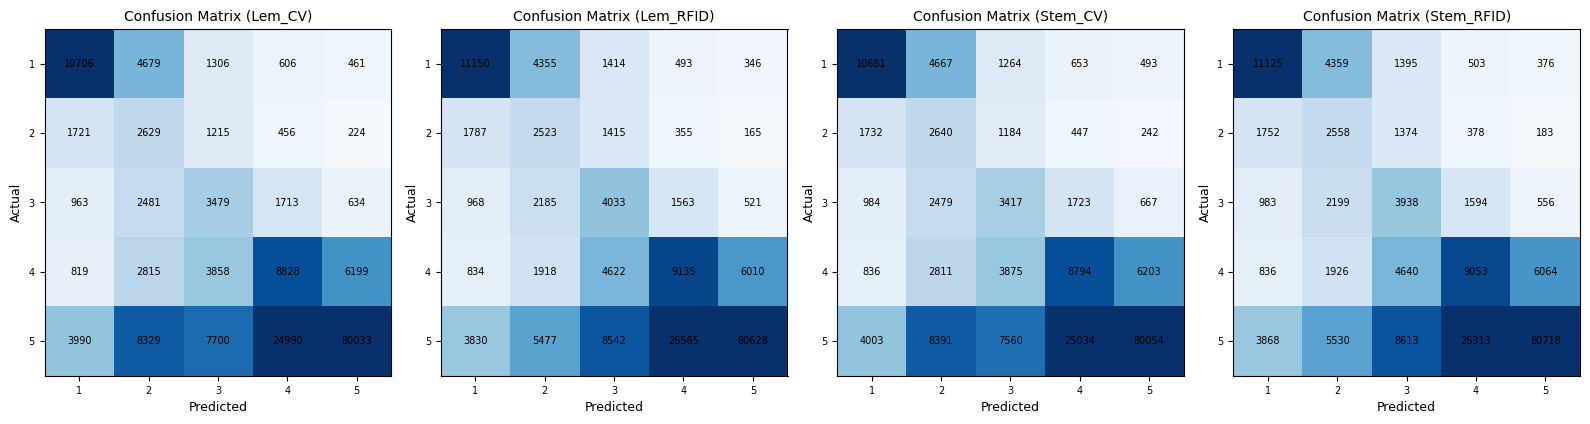

Lem_TFIDF: Train Accuracy - 0.8439, Test Accuracy - 0.5943
Stem_TFIDF: Train Accuracy - 0.8285, Test Accuracy - 0.5939
Lem_CV: Train Accuracy - 0.6849, Test Accuracy - 0.5844
Stem_CV: Train Accuracy - 0.6727, Test Accuracy - 0.5839


In [104]:
combinations = ['Lem_CV', 'Lem_RFID', 'Stem_CV', 'Stem_RFID']

plt.figure(figsize=(16, 4))

for i, combination in enumerate(combinations, 1):
    plt.subplot(1, 4, i)
    
    # Get y_test and y_pred_test for the current combination
    y_test_comb = globals()[f"y_test"]
    y_pred_test_comb = globals()[f"y_pred_test_svm_{combination.lower()}"]
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test_comb, y_pred_test_comb)

    print(cm)
    
    # Plotting Confusion Matrix using imshow
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 10000)
    
    # Adding annotations
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)
    
    plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
    plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
    plt.title(f'Confusion Matrix ({combination})', fontsize=10)
    plt.xlabel('Predicted', fontsize=9)
    plt.ylabel('Actual', fontsize=9)

plt.tight_layout()
# plt.savefig('../../images/SVMUSConfMatrix.png')
plt.show()

accuracy_scores = {
    'Lem_CV': {'Train': accuracy_train_svm_lem_cv, 'Test': accuracy_test_svm_lem_cv},
    'Lem_TFIDF': {'Train': accuracy_train_svm_lem_rfid, 'Test': accuracy_test_svm_lem_rfid},
    'Stem_CV': {'Train': accuracy_train_svm_stem_cv, 'Test': accuracy_test_svm_stem_cv},
    'Stem_TFIDF': {'Train': accuracy_train_svm_stem_rfid, 'Test': accuracy_test_svm_stem_rfid},
}

# Sorting based on the test accuracy
sorted_accuracy_scores = sorted(accuracy_scores.items(), key=lambda x: x[1]['Train'], reverse=True)

# Displaying the sorted results
for combination, scores in sorted_accuracy_scores:
    print(f"{combination}: Train Accuracy - {scores['Train']:.4f}, Test Accuracy - {scores['Test']:.4f}")

### Best SVM Model

In [12]:
# Best SVM Classification Model

# Best results achieved without Sampling
best_svm_train_tokens = column_lemmatizer(X_train_nosample)
best_svm_test_tokens = column_lemmatizer(X_test)

best_svm_train_vectors, best_svm_test_vectors = tfidf_vectorize_data(best_svm_train_tokens, best_svm_test_tokens)

# best_logistic_train_sampled = 

scaler = MaxAbsScaler()
best_svm_train_scaled = scaler.fit_transform(best_svm_train_vectors)
best_svm_test_scaled = scaler.transform(best_svm_test_vectors)
print(type(best_svm_train_scaled))

print(f'preprocessing complete\ntrain shape: {best_svm_train_scaled.shape}\ntest shape: {best_svm_test_scaled.shape}\n\n')

best_svm_model = SVC()
best_svm_model.fit(best_svm_train_scaled, y_train_nosample)

print('model fitted')

y_pred_train_svm_best = best_svm_model.predict(best_svm_train_scaled)
print('train predicted')

y_pred_test_svm_best = best_svm_model.predict(best_svm_test_scaled)
print('test predicted')

accuracy_train_svm_best = accuracy_score(y_train_nosample, y_pred_train_svm_best)
precision_train_svm_best = precision_score(y_train_nosample, y_pred_train_svm_best, average='weighted')
recall_train_svm_best = recall_score(y_train_nosample, y_pred_train_svm_best, average='weighted')
f1_train_svm_best = f1_score(y_train_nosample, y_pred_train_svm_best, average='weighted')
r2_train_svm_best = r2_score(y_train_nosample, y_pred_train_svm_best)
mse_train_svm_best = mean_squared_error(y_train_nosample, y_pred_train_svm_best)

accuracy_test_svm_best = accuracy_score(y_test, y_pred_test_svm_best)
precision_test_svm_best = precision_score(y_test, y_pred_test_svm_best, average='weighted')
recall_test_svm_best = recall_score(y_test, y_pred_test_svm_best, average='weighted')
f1_test_svm_best = f1_score(y_test, y_pred_test_svm_best, average='weighted')
r2_test_svm_best = r2_score(y_test, y_pred_test_svm_best)
mse_test_svm_best = mean_squared_error(y_test, y_pred_test_svm_best)

print('Train Results')
print("Accuracy Score: SVM Classification Train Data (lem - TFIDF):", accuracy_train_svm_best)
print("Precision Score: SVM Classification Train Data (lem - TFIDF):", precision_train_svm_best)
print("Recall Score: SVM Classification Data (lem - TFIDF):", recall_train_svm_best)
print("F1 Score: SVM Classification Train Data (lem - TFIDF):", f1_train_svm_best)
print("R Squared Score: SVM Classification Train Data (lem - TFIDF):", r2_train_svm_best)
print("Mean Squared Error Score: SVM Classification Train Data (lem - TFIDF):", mse_train_svm_best)
print()
print('Test Results')
print("Accuracy Score: SVM Classification Test Data (lem - TFIDF):", accuracy_test_svm_best)
print("Precision Score: SVM Classification Test Data (lem - TFIDF):", precision_test_svm_best)
print("Recall Score: SVM Classification Test Data (lem - TFIDF):", recall_test_svm_best)
print("F1 Score: SVM Classification Test Data (lem - TFIDF):", f1_test_svm_best)
print("R Squared Score: SVM Classification Test Data (lem - TFIDF):", r2_test_svm_best)
print("Mean Squared Error Score: SVM Classification Test Data (lem - TFIDF):", mse_test_svm_best)

<class 'scipy.sparse._csr.csr_matrix'>
preprocessing complete
train shape: (421943, 54434)
test shape: (180834, 54434)


model fitted
train predicted
test predicted
Train Results
Accuracy Score: SVM Classification Train Data (lem - TFIDF): 0.873821819534866
Precision Score: SVM Classification Train Data (lem - TFIDF): 0.8819460465732112
Recall Score: SVM Classification Data (lem - TFIDF): 0.873821819534866
F1 Score: SVM Classification Train Data (lem - TFIDF): 0.8559704762498526
R Squared Score: SVM Classification Train Data (lem - TFIDF): 0.7624378955825442
Mean Squared Error Score: SVM Classification Train Data (lem - TFIDF): 0.4030710309212382

Test Results
Accuracy Score: SVM Classification Test Data (lem - TFIDF): 0.7700266542796156
Precision Score: SVM Classification Test Data (lem - TFIDF): 0.7253989105671017
Recall Score: SVM Classification Test Data (lem - TFIDF): 0.7700266542796156
F1 Score: SVM Classification Test Data (lem - TFIDF): 0.7088178437536704
R Squared Score: SVM C

[[ 38426     24    198    121   3100]
 [  3636   7448    402    235   2768]
 [  1737     33  12609    597   6406]
 [   984     24    329  20420  31200]
 [   872      5    143    426 289800]]
[[ 12833     74    292    141   4418]
 [  2842    200    384    168   2651]
 [  1627     73   1214    749   5607]
 [   778     24    495   2225  18997]
 [  1305     24    231    707 122775]]


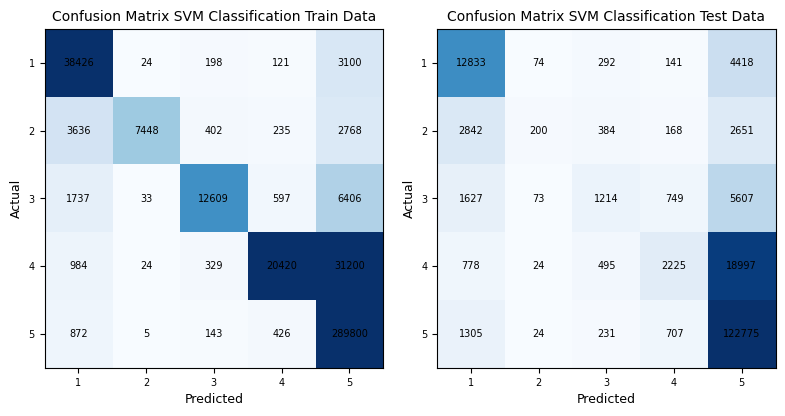

In [25]:
# Calculate confusion matrix
plt.figure(figsize=(8, 4))

# Calculate confusion matrix
cm = confusion_matrix(y_train_nosample, y_pred_train_svm_best)

print(cm)

# Plotting Confusion Matrix using imshow
plt.subplot(1, 2, 1)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 20000)

# Adding annotations
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)

plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.xlabel('Predicted', fontsize=9)
plt.ylabel('Actual', fontsize=9)
plt.title(f'Confusion Matrix SVM Classification Train Data', fontsize=10)

cm = confusion_matrix(y_test, y_pred_test_svm_best)

print(cm)
plt.subplot(1, 2, 2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 20000)

# Adding annotations
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)

plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.xlabel('Predicted', fontsize=9)
plt.ylabel('Actual', fontsize=9)

plt.title(f'Confusion Matrix SVM Classification Test Data', fontsize=10)
plt.tight_layout()
# plt.savefig('../../images/SVMBestConfMatrix.png')
plt.show()

# 3. k-Nearest Neighbors (kNN)

In [26]:
# a) KNN on Lemmatized CountVectorized data

# Set k to the desired number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)  # You can adjust n_neighbors as needed
knn_model.fit(X_lem_CV_train, y_train)

y_pred_train_knn_lem_cv = knn_model.predict(X_lem_CV_train)
y_pred_test_knn_lem_cv = knn_model.predict(X_lem_CV_test)

knn_report_train_lem_cv_imbalanced = classification_report_imbalanced(y_train, y_pred_train_knn_lem_cv)
knn_report_test_lem_cv_imbalanced = classification_report_imbalanced(y_test, y_pred_test_knn_lem_cv)

accuracy_train_knn_lem_cv = accuracy_score(y_train, y_pred_train_knn_lem_cv)
accuracy_test_knn_lem_cv = accuracy_score(y_test, y_pred_test_knn_lem_cv)

print("KNN - Classification Report: Train Data (lem_cv) - imbalanced:\n", knn_report_train_lem_cv_imbalanced)
print("\nKNN - Classification Report: Test Data (lem_cv) - imbalanced:\n", knn_report_test_lem_cv_imbalanced)
print("\nAccuracy Score: Train Data (lem_cv):", accuracy_train_knn_lem_cv)
print("Accuracy Score: Test Data (lem_cv):", accuracy_test_knn_lem_cv)

KNN - Classification Report: Train Data (lem_cv) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.58      0.67      0.88      0.62      0.77      0.58     14489
          2       0.57      0.49      0.91      0.53      0.67      0.43     14489
          3       0.58      0.43      0.92      0.49      0.63      0.38     14489
          4       0.49      0.51      0.87      0.50      0.67      0.43     14489
          5       0.56      0.67      0.87      0.61      0.76      0.57     14489

avg / total       0.56      0.55      0.89      0.55      0.70      0.48     72445


KNN - Classification Report: Test Data (lem_cv) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.37      0.44      0.92      0.40      0.63      0.38     17758
          2       0.10      0.25      0.92      0.14      0.48      0.22      6245
          3       0.13      0.24      

In [27]:
# b) KNN on Lemmatized TFIDFVectorized data

# Set k to the desired number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)  # You can adjust n_neighbors as needed
knn_model.fit(X_lem_RFID_train, y_train)

y_pred_train_knn_lem_rfid = knn_model.predict(X_lem_RFID_train)
y_pred_test_knn_lem_rfid = knn_model.predict(X_lem_RFID_test)

knn_report_train_lem_rfid_imbalanced = classification_report_imbalanced(y_train, y_pred_train_knn_lem_rfid)
knn_report_test_lem_rfid_imbalanced = classification_report_imbalanced(y_test, y_pred_test_knn_lem_rfid)

accuracy_train_knn_lem_rfid = accuracy_score(y_train, y_pred_train_knn_lem_rfid)
accuracy_test_knn_lem_rfid = accuracy_score(y_test, y_pred_test_knn_lem_rfid)

print("KNN - Classification Report: Train Data (lem_tfidf) - imbalanced:\n", knn_report_train_lem_rfid_imbalanced)
print("\nKNN - Classification Report: Test Data (lem_tfidf) - imbalanced:\n", knn_report_test_lem_rfid_imbalanced)
print("\nAccuracy Score: Train Data (lem_tfidf):", accuracy_train_knn_lem_rfid)
print("Accuracy Score: Test Data (lem_tfidf):", accuracy_test_knn_lem_rfid)

KNN - Classification Report: Train Data (lem_tfidf) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.26      0.96      0.30      0.40      0.54      0.31     14489
          2       0.49      0.13      0.97      0.20      0.35      0.11     14489
          3       0.37      0.12      0.95      0.18      0.33      0.10     14489
          4       0.51      0.17      0.96      0.25      0.40      0.15     14489
          5       0.76      0.26      0.98      0.39      0.51      0.24     14489

avg / total       0.47      0.33      0.83      0.28      0.43      0.18     72445


KNN - Classification Report: Test Data (lem_tfidf) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.15      0.92      0.43      0.25      0.62      0.41     17758
          2       0.06      0.07      0.97      0.07      0.25      0.06      6245
          3       0.04      0.08

In [15]:
# c) KNN on Stemmatized CountVectorized data

# Set k to the desired number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)  # You can adjust n_neighbors as needed
knn_model.fit(X_stem_CV_train, y_train)

y_pred_train_knn_stem_cv = knn_model.predict(X_stem_CV_train)
y_pred_test_knn_stem_cv = knn_model.predict(X_stem_CV_test)

knn_report_train_stem_cv_imbalanced = classification_report_imbalanced(y_train, y_pred_train_knn_stem_cv)
knn_report_test_stem_cv_imbalanced = classification_report_imbalanced(y_test, y_pred_test_knn_stem_cv)

accuracy_train_knn_stem_cv = accuracy_score(y_train, y_pred_train_knn_stem_cv)
accuracy_test_knn_stem_cv = accuracy_score(y_test, y_pred_test_knn_stem_cv)

print("KNN - Classification Report: Train Data (stem_cv) - imbalanced:\n", knn_report_train_stem_cv_imbalanced)
print("\nKNN - Classification Report: Test Data (stem_cv) - imbalanced:\n", knn_report_test_stem_cv_imbalanced)
print("\nAccuracy Score: Train Data (stem_cv):", accuracy_train_knn_stem_cv)
print("Accuracy Score: Test Data (stem_cv):", accuracy_test_knn_stem_cv)

KNN - Classification Report: Train Data (stem_cv) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.58      0.68      0.88      0.63      0.77      0.59     14489
          2       0.57      0.48      0.91      0.53      0.66      0.42     14489
          3       0.57      0.45      0.91      0.50      0.64      0.39     14489
          4       0.49      0.51      0.87      0.50      0.66      0.42     14489
          5       0.57      0.66      0.88      0.61      0.76      0.56     14489

avg / total       0.56      0.56      0.89      0.55      0.70      0.48     72445


KNN - Classification Report: Test Data (stem_cv) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.38      0.46      0.92      0.42      0.65      0.40     17758
          2       0.11      0.25      0.93      0.15      0.49      0.22      6245
          3       0.12      0.24    

In [29]:
# d) KNN on Stemmatized TFIDFVectorized data

# Set k to the desired number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)  # You can adjust n_neighbors as needed
knn_model.fit(X_stem_RFID_train, y_train)

y_pred_train_knn_stem_rfid = knn_model.predict(X_stem_RFID_train)
y_pred_test_knn_stem_rfid = knn_model.predict(X_stem_RFID_test)

knn_report_train_stem_rfid_imbalanced = classification_report_imbalanced(y_train, y_pred_train_knn_stem_rfid)
knn_report_test_stem_rfid_imbalanced = classification_report_imbalanced(y_test, y_pred_test_knn_stem_rfid)

accuracy_train_knn_stem_rfid = accuracy_score(y_train, y_pred_train_knn_stem_rfid)
accuracy_test_knn_stem_rfid = accuracy_score(y_test, y_pred_test_knn_stem_rfid)

print("KNN - Classification Report: Train Data (stem_tfidf) - imbalanced:\n", knn_report_train_stem_rfid_imbalanced)
print("\nKNN - Classification Report: Test Data (stem_tfidf) - imbalanced:\n", knn_report_test_stem_rfid_imbalanced)
print("\nAccuracy Score: Train Data (stem_tfidf):", accuracy_train_knn_stem_rfid)
print("Accuracy Score: Test Data (stem_tfidf):", accuracy_test_knn_stem_rfid)

KNN - Classification Report: Train Data (stem_tfidf) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.26      0.94      0.33      0.41      0.56      0.33     14489
          2       0.48      0.15      0.96      0.23      0.38      0.13     14489
          3       0.42      0.13      0.95      0.20      0.35      0.12     14489
          4       0.51      0.18      0.96      0.27      0.42      0.16     14489
          5       0.74      0.29      0.97      0.42      0.53      0.26     14489

avg / total       0.48      0.34      0.83      0.30      0.45      0.20     72445


KNN - Classification Report: Test Data (stem_tfidf) - imbalanced:
                    pre       rec       spe        f1       geo       iba       sup

          1       0.15      0.90      0.44      0.26      0.63      0.42     17758
          2       0.06      0.08      0.96      0.07      0.27      0.07      6245
          3       0.05      0.

## Summary - k-Nearest Neighbors

In [30]:
# a) Lemmatized CountVectorized data
knn_report_train_lem_cv_imbalanced_last = [accuracy_train_knn_lem_cv*100] + [float(value) for value in knn_report_train_lem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
knn_report_test_lem_cv_imbalanced_last = [accuracy_test_knn_lem_cv*100] + [float(value) for value in knn_report_test_lem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_knn_report_lem_cv_imbalanced = pd.DataFrame([knn_report_train_lem_cv_imbalanced_last, knn_report_test_lem_cv_imbalanced_last], columns=column_names)
final_knn_report_lem_cv_imbalanced['Data Type'] = ['Lemmatized Count Vectorized', 'Lemmatized Count Vectorized']
final_knn_report_lem_cv_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_knn_report_lem_cv_imbalanced.set_index('Data Type', inplace=True)
final_knn_report_lem_cv_imbalanced.index.name = None

# Reorder columns
final_knn_report_lem_cv_imbalanced = final_knn_report_lem_cv_imbalanced[['Train/Test'] + column_names]


# b) Lemmatized TFIDFVectorized data
knn_report_train_lem_rfid_imbalanced_last = [accuracy_train_knn_lem_rfid*100] + [float(value) for value in knn_report_train_lem_rfid_imbalanced.split()[-7:]] # Extracting the last 6 values
knn_report_test_lem_rfid_imbalanced_last = [accuracy_test_knn_lem_rfid*100] + [float(value) for value in knn_report_test_lem_rfid_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_knn_report_lem_rfid_imbalanced = pd.DataFrame([knn_report_train_lem_rfid_imbalanced_last, knn_report_test_lem_rfid_imbalanced_last], columns=column_names)
final_knn_report_lem_rfid_imbalanced['Data Type'] = ['Lemmatized TFIDF Vectorized', 'Lemmatized TFIDF Vectorized']
final_knn_report_lem_rfid_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_knn_report_lem_rfid_imbalanced.set_index('Data Type', inplace=True)
final_knn_report_lem_rfid_imbalanced.index.name = None

# Reorder columns
final_knn_report_lem_rfid_imbalanced = final_knn_report_lem_rfid_imbalanced[['Train/Test'] + column_names]


# c) Stemmatized CountVectorized data
knn_report_train_stem_cv_imbalanced_last = [accuracy_train_knn_stem_cv*100] + [float(value) for value in knn_report_train_stem_cv_imbalanced.split()[-7:]] # Extracting the last 6 values
knn_report_test_stem_cv_imbalanced_last = [accuracy_test_knn_stem_cv*100] + [float(value) for value in knn_report_test_stem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_knn_report_stem_cv_imbalanced = pd.DataFrame([knn_report_train_stem_cv_imbalanced_last, knn_report_test_stem_cv_imbalanced_last], columns=column_names)
final_knn_report_stem_cv_imbalanced['Data Type'] = ['Stemmatized Count Vectorized', 'Stemmatized Count Vectorized']
final_knn_report_stem_cv_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_knn_report_stem_cv_imbalanced.set_index('Data Type', inplace=True)
final_knn_report_stem_cv_imbalanced.index.name = None

# Reorder columns
final_knn_report_stem_cv_imbalanced = final_knn_report_stem_cv_imbalanced[['Train/Test'] + column_names]


# d) Stemmatized TFIDFVectorized data
knn_report_train_stem_rfid_imbalanced_last = [accuracy_train_knn_stem_rfid*100]+ [float(value) for value in knn_report_train_stem_rfid_imbalanced.split()[-7:]] # Extracting the last 6 values
knn_report_test_stem_rfid_imbalanced_last = [accuracy_test_knn_stem_rfid*100] + [float(value) for value in knn_report_test_stem_rfid_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_knn_report_stem_rfid_imbalanced = pd.DataFrame([knn_report_train_stem_rfid_imbalanced_last, knn_report_test_stem_rfid_imbalanced_last], columns=column_names)
final_knn_report_stem_rfid_imbalanced['Data Type'] = ['Stemmatized TFIDF Vectorized', 'Stemmatized TFIDF Vectorized']
final_knn_report_stem_rfid_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_knn_report_stem_rfid_imbalanced.set_index('Data Type', inplace=True)
final_knn_report_stem_rfid_imbalanced.index.name = None

# Reorder columns
final_knn_report_stem_rfid_imbalanced = final_knn_report_stem_rfid_imbalanced[['Train/Test'] + column_names]

### Averaged classification report for k-Nearest Neighbors (kNN)

In [31]:
final_knn_report = pd.concat([final_knn_report_lem_cv_imbalanced,
                    final_knn_report_lem_rfid_imbalanced,
                    final_knn_report_stem_cv_imbalanced,
                    final_knn_report_stem_rfid_imbalanced])

final_knn_report.head(8)

,Train/Test,Accuracy,Precision,Recall,Specificity,F1-Score,Geometric Mean,Index Balanced Accuracy (IBA),Support
Lemmatized Count Vectorized,Train,55.469667,0.56,0.55,0.89,0.55,0.70,0.48,72445.0
Lemmatized Count Vectorized,Test,48.681111,0.66,0.49,0.81,0.54,0.62,0.38,180834.0
Lemmatized TFIDF Vectorized,Train,32.584719,0.47,0.33,0.83,0.28,0.43,0.18,72445.0
Lemmatized TFIDF Vectorized,Test,24.776314,0.67,0.25,0.89,0.27,0.42,0.18,180834.0
Stemmatized Count Vectorized,Train,55.910001,0.56,0.56,0.89,0.55,0.70,0.48,72445.0
Stemmatized Count Vectorized,Test,49.558158,0.66,0.50,0.81,0.55,0.63,0.39,180834.0
Stemmatized TFIDF Vectorized,Train,33.965077,0.48,0.34,0.83,0.30,0.45,0.20,72445.0
Stemmatized TFIDF Vectorized,Test,26.083590,0.67,0.26,0.89,0.29,0.44,0.19,180834.0


### Confusion Matrix for k-Nearest Neighbors (kNN)

[[ 7777  3870  2012  2116  1983]
 [ 1945  1567   965   996   772]
 [ 1702  1588  2195  2162  1623]
 [ 2187  2062  2902  7809  7559]
 [ 7538  6400  8785 33635 68684]]
[[16262   843   304   195   154]
 [ 5509   415   165    91    65]
 [ 7603   448   706   335   178]
 [15255   775  2157  2428  1904]
 [65318  3970 12636 18125 24993]]
[[ 8085  3882  1947  2094  1750]
 [ 1968  1627   953   954   743]
 [ 1694  1626  2083  2271  1596]
 [ 2063  2099  2969  7829  7559]
 [ 7040  6109  9187 32712 69994]]
[[15929   942   418   254   215]
 [ 5325   477   240   117    86]
 [ 7330   567   740   392   241]
 [14816  1055  1945  2632  2071]
 [63406  4962 10381 18903 27390]]


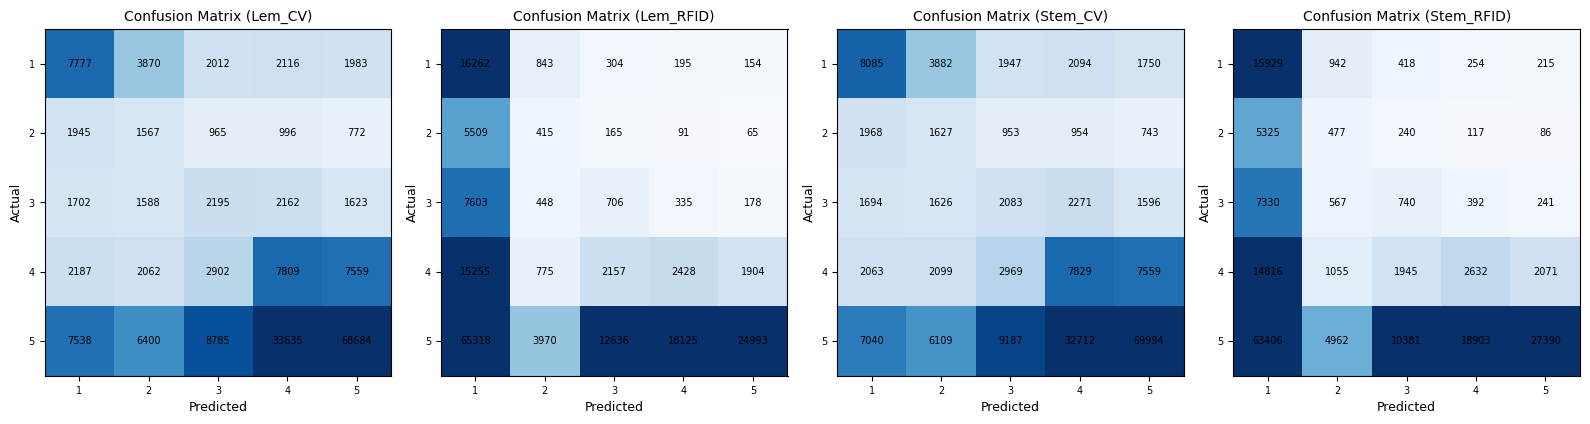

Stem_CV: Train Accuracy - 0.5591, Test Accuracy - 0.4956
Lem_CV: Train Accuracy - 0.5547, Test Accuracy - 0.4868
Stem_TFIDF: Train Accuracy - 0.3397, Test Accuracy - 0.2608
Lem_TFIDF: Train Accuracy - 0.3258, Test Accuracy - 0.2478


In [103]:
combinations = ['Lem_CV', 'Lem_RFID', 'Stem_CV', 'Stem_RFID']

plt.figure(figsize=(16, 4))

for i, combination in enumerate(combinations, 1):
    plt.subplot(1, 4, i)
    
    # Get y_test and y_pred_test for the current combination
    y_test_comb = globals()[f"y_test"]
    y_pred_test_comb = globals()[f"y_pred_test_knn_{combination.lower()}"]
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test_comb, y_pred_test_comb)

    print(cm)
    
    # Plotting Confusion Matrix using imshow
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 10000)
    
    # Adding annotations
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)
    
    plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
    plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
    plt.title(f'Confusion Matrix ({combination})', fontsize=10)
    plt.xlabel('Predicted', fontsize=9)
    plt.ylabel('Actual', fontsize=9)

plt.tight_layout()
# plt.savefig('../../images/KNNUSConfMatrix.png')
plt.show()

accuracy_scores = {
    'Lem_CV': {'Train': accuracy_train_knn_lem_cv, 'Test': accuracy_test_knn_lem_cv},
    'Lem_TFIDF': {'Train': accuracy_train_knn_lem_rfid, 'Test': accuracy_test_knn_lem_rfid},
    'Stem_CV': {'Train': accuracy_train_knn_stem_cv, 'Test': accuracy_test_knn_stem_cv},
    'Stem_TFIDF': {'Train': accuracy_train_knn_stem_rfid, 'Test': accuracy_test_knn_stem_rfid},
}

# Sorting based on the test accuracy
sorted_accuracy_scores = sorted(accuracy_scores.items(), key=lambda x: x[1]['Train'], reverse=True)

# Displaying the sorted results
for combination, scores in sorted_accuracy_scores:
    print(f"{combination}: Train Accuracy - {scores['Train']:.4f}, Test Accuracy - {scores['Test']:.4f}")

### Best KNN Model

In [16]:
accuracy_train_knn_best = accuracy_score(y_train, y_pred_train_knn_stem_cv)
precision_train_knn_best = precision_score(y_train, y_pred_train_knn_stem_cv, average='weighted')
recall_train_knn_best = recall_score(y_train, y_pred_train_knn_stem_cv, average='weighted')
f1_train_knn_best = f1_score(y_train, y_pred_train_knn_stem_cv, average='weighted')
r2_train_knn_best = r2_score(y_train, y_pred_train_knn_stem_cv)
mse_train_knn_best = mean_squared_error(y_train, y_pred_train_knn_stem_cv)

accuracy_test_knn_best = accuracy_score(y_test, y_pred_test_knn_stem_cv)
precision_test_knn_best = precision_score(y_test, y_pred_test_knn_stem_cv, average='weighted')
recall_test_knn_best = recall_score(y_test, y_pred_test_knn_stem_cv, average='weighted')
f1_test_knn_best = f1_score(y_test, y_pred_test_knn_stem_cv, average='weighted')
r2_test_knn_best = r2_score(y_test, y_pred_test_knn_stem_cv)
mse_test_knn_best = mean_squared_error(y_test, y_pred_test_knn_stem_cv)

print('Train Results')
print("Accuracy Score: KNN Classification Train Data (stem - CV):", accuracy_train_knn_best)
print("Precision Score: KNN Classification Train Data (stem - CV):", precision_train_knn_best)
print("Recall Score: KNN Classification Data (stem - CV):", recall_train_knn_best)
print("F1 Score: KNN Classification Train Data (stem - CV):", f1_train_knn_best)
print("R Squared Score: KNN Classification Train Data (stem - CV):", r2_train_knn_best)
print("Mean Squared Error Score: KNN Classification Train Data (stem - CV):", mse_train_knn_best)
print()
print('Test Results')
print("Accuracy Score: KNN Classification Test Data (stem - CV):", accuracy_test_knn_best)
print("Precision Score: KNN Classification Test Data (stem - CV):", precision_test_knn_best)
print("Recall Score: KNN Classification Test Data (stem - CV):", recall_test_knn_best)
print("F1 Score: KNN Classification Test Data (stem - CV):", f1_test_knn_best)
print("R Squared Score: KNN Classification Test Data (stem - CV):", r2_test_knn_best)
print("Mean Squared Error Score: KNN Classification Test Data (stem - CV):", mse_test_knn_best)

Train Results
Accuracy Score: KNN Classification Train Data (stem - CV): 0.5561322382497067
Precision Score: KNN Classification Train Data (stem - CV): 0.5565377993486952
Recall Score: KNN Classification Data (stem - CV): 0.5561322382497067
F1 Score: KNN Classification Train Data (stem - CV): 0.5526984636249495
R Squared Score: KNN Classification Train Data (stem - CV): 0.2315411691628132
Mean Squared Error Score: KNN Classification Train Data (stem - CV): 1.5369176616743736

Test Results
Accuracy Score: KNN Classification Test Data (stem - CV): 0.48371434575356403
Precision Score: KNN Classification Test Data (stem - CV): 0.659582227664312
Recall Score: KNN Classification Test Data (stem - CV): 0.48371434575356403
F1 Score: KNN Classification Test Data (stem - CV): 0.5412687207785216
R Squared Score: KNN Classification Test Data (stem - CV): -0.21412880881307972
Mean Squared Error Score: KNN Classification Test Data (stem - CV): 2.0496975126358983


[[9868 1687  931 1115  888]
 [3295 7005 1407 1542 1240]
 [2135 1965 6503 2278 1608]
 [1054  988 1708 7376 3363]
 [ 663  544  895 2850 9537]]
[[ 8127  3701  2119  2138  1673]
 [ 1952  1592  1027   981   693]
 [ 1722  1587  2231  2209  1521]
 [ 2111  1991  3326  7572  7519]
 [ 7388  5780 10200 33724 67950]]


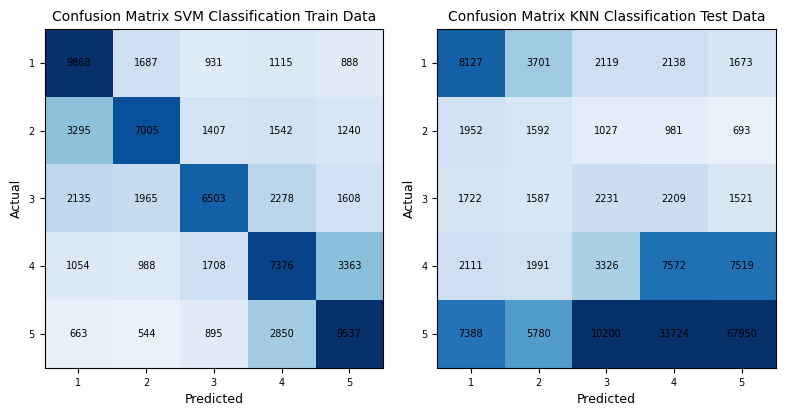

In [28]:
# Calculate confusion matrix
plt.figure(figsize=(8, 4))

# Calculate confusion matrix
cm = confusion_matrix(y_train, y_pred_train_knn_stem_cv)

print(cm)

# Plotting Confusion Matrix using imshow
plt.subplot(1, 2, 1)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 8000)

# Adding annotations
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)

plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.xlabel('Predicted', fontsize=9)
plt.ylabel('Actual', fontsize=9)
plt.title(f'Confusion Matrix SVM Classification Train Data', fontsize=10)

cm = confusion_matrix(y_test, y_pred_test_knn_stem_cv)

print(cm)
plt.subplot(1, 2, 2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 10000)

# Adding annotations
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)

plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.xlabel('Predicted', fontsize=9)
plt.ylabel('Actual', fontsize=9)

plt.title(f'Confusion Matrix KNN Classification Test Data', fontsize=10)
plt.tight_layout()
# plt.savefig('../../images/KNNBestConfMatrix.png')
plt.show()

# 4. Decision Tree Classifier

In [33]:
# a) Decision Tree on Lemmatized CountVectorized data

# Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_lem_CV_train, y_train)
y_pred_train_dt_lem_cv = dt_model.predict(X_lem_CV_train)
y_pred_test_dt_lem_cv = dt_model.predict(X_lem_CV_test)

# Decision Tree classification reports and accuracy scores
dt_report_train_lem_cv_imbalanced = classification_report_imbalanced(y_train, y_pred_train_dt_lem_cv)
dt_report_test_lem_cv_imbalanced = classification_report_imbalanced(y_test, y_pred_test_dt_lem_cv)
accuracy_train_dt_lem_cv = accuracy_score(y_train, y_pred_train_dt_lem_cv)
accuracy_test_dt_lem_cv = accuracy_score(y_test, y_pred_test_dt_lem_cv)

# Print results
print("Decision Tree - Classification Report: Train Data (lem_cv):\n", dt_report_train_lem_cv_imbalanced)
print("\nDecision Tree - Classification Report: Test Data (lem_cv):\n", dt_report_test_lem_cv_imbalanced)
print("\nAccuracy Score: Train Data (lem_cv):", accuracy_train_dt_lem_cv)
print("Accuracy Score: Test Data (lem_cv):", accuracy_test_dt_lem_cv)

Decision Tree - Classification Report: Train Data (lem_cv):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.98      0.99      0.99      0.98      0.99      0.98     14489
          2       0.99      0.98      1.00      0.98      0.99      0.98     14489
          3       0.98      0.96      1.00      0.97      0.98      0.95     14489
          4       0.92      0.94      0.98      0.93      0.96      0.92     14489
          5       0.94      0.94      0.98      0.94      0.96      0.92     14489

avg / total       0.96      0.96      0.99      0.96      0.98      0.95     72445


Decision Tree - Classification Report: Test Data (lem_cv):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.40      0.45      0.93      0.43      0.65      0.40     17758
          2       0.10      0.31      0.90      0.15      0.53      0.26      6245
          3       0.12      0.30      0.88  

In [34]:
# b) Decision Tree on Lemmatized TFIDFVectorized data

# Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_lem_RFID_train, y_train)
y_pred_train_dt_lem_rfid = dt_model.predict(X_lem_RFID_train)
y_pred_test_dt_lem_rfid = dt_model.predict(X_lem_RFID_test)

# Decision Tree classification reports and accuracy scores
dt_report_train_lem_rfid_imbalanced = classification_report_imbalanced(y_train, y_pred_train_dt_lem_rfid)
dt_report_test_lem_rfid_imbalanced = classification_report_imbalanced(y_test, y_pred_test_dt_lem_rfid)
accuracy_train_dt_lem_rfid = accuracy_score(y_train, y_pred_train_dt_lem_rfid)
accuracy_test_dt_lem_rfid = accuracy_score(y_test, y_pred_test_dt_lem_rfid)

# Print results
print("Decision Tree - Classification Report: Train Data (lem_tfidf):\n", dt_report_train_lem_rfid_imbalanced)
print("\nDecision Tree - Classification Report: Test Data (lem_tfidf):\n", dt_report_test_lem_rfid_imbalanced)
print("\nAccuracy Score: Train Data (lem_tfidf):", accuracy_train_dt_lem_rfid)
print("Accuracy Score: Test Data (lem_tfidf):", accuracy_test_dt_lem_rfid)

Decision Tree - Classification Report: Train Data (lem_tfidf):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.98      0.99      0.99      0.98      0.99      0.98     14489
          2       0.99      0.98      1.00      0.98      0.99      0.98     14489
          3       0.98      0.96      1.00      0.97      0.98      0.95     14489
          4       0.92      0.94      0.98      0.93      0.96      0.92     14489
          5       0.94      0.94      0.98      0.94      0.96      0.92     14489

avg / total       0.96      0.96      0.99      0.96      0.98      0.95     72445


Decision Tree - Classification Report: Test Data (lem_tfidf):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.42      0.47      0.93      0.44      0.66      0.42     17758
          2       0.10      0.32      0.89      0.15      0.53      0.27      6245
          3       0.12      0.31      

In [35]:
# c) Decision Tree on Stemmatized CountVectorized data

# Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_stem_CV_train, y_train)
y_pred_train_dt_stem_cv = dt_model.predict(X_stem_CV_train)
y_pred_test_dt_stem_cv = dt_model.predict(X_stem_CV_test)

# Decision Tree classification reports and accuracy scores
dt_report_train_stem_cv_imbalanced = classification_report_imbalanced(y_train, y_pred_train_dt_stem_cv)
dt_report_test_stem_cv_imbalanced = classification_report_imbalanced(y_test, y_pred_test_dt_stem_cv)
accuracy_train_dt_stem_cv = accuracy_score(y_train, y_pred_train_dt_stem_cv)
accuracy_test_dt_stem_cv = accuracy_score(y_test, y_pred_test_dt_stem_cv)

# Print results
print("Decision Tree - Classification Report: Train Data (stem_cv):\n", dt_report_train_stem_cv_imbalanced)
print("\nDecision Tree - Classification Report: Test Data (stem_cv):\n", dt_report_test_stem_cv_imbalanced)
print("\nAccuracy Score: Train Data (stem_cv):", accuracy_train_dt_stem_cv)
print("Accuracy Score: Test Data (stem_cv):", accuracy_test_dt_stem_cv)

Decision Tree - Classification Report: Train Data (stem_cv):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.98      0.99      0.99      0.98      0.99      0.98     14489
          2       0.99      0.98      1.00      0.98      0.99      0.97     14489
          3       0.98      0.96      1.00      0.97      0.98      0.95     14489
          4       0.91      0.94      0.98      0.93      0.96      0.91     14489
          5       0.94      0.94      0.98      0.94      0.96      0.92     14489

avg / total       0.96      0.96      0.99      0.96      0.97      0.95     72445


Decision Tree - Classification Report: Test Data (stem_cv):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.41      0.45      0.93      0.43      0.65      0.40     17758
          2       0.10      0.32      0.90      0.15      0.54      0.27      6245
          3       0.12      0.30      0.88

In [36]:
# d) Decision Tree on Lemmatized TFIDFVectorized data

# Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_stem_RFID_train, y_train)
y_pred_train_dt_stem_rfid = dt_model.predict(X_stem_RFID_train)
y_pred_test_dt_stem_rfid = dt_model.predict(X_stem_RFID_test)

# Decision Tree classification reports and accuracy scores
dt_report_train_stem_rfid_imbalanced = classification_report_imbalanced(y_train, y_pred_train_dt_stem_rfid)
dt_report_test_stem_rfid_imbalanced = classification_report_imbalanced(y_test, y_pred_test_dt_stem_rfid)
accuracy_train_dt_stem_rfid = accuracy_score(y_train, y_pred_train_dt_stem_rfid)
accuracy_test_dt_stem_rfid = accuracy_score(y_test, y_pred_test_dt_stem_rfid)

# Print results
print("Decision Tree - Classification Report: Train Data (stem_tfidf):\n", dt_report_train_stem_rfid_imbalanced)
print("\nDecision Tree - Classification Report: Test Data (stem_tfidf):\n", dt_report_test_stem_rfid_imbalanced)
print("\nAccuracy Score: Train Data (stem_tfidf):", accuracy_train_dt_stem_rfid)
print("Accuracy Score: Test Data (stem_tfidf):", accuracy_test_dt_stem_rfid)

Decision Tree - Classification Report: Train Data (stem_tfidf):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.98      0.99      0.99      0.98      0.99      0.98     14489
          2       0.99      0.98      1.00      0.98      0.99      0.97     14489
          3       0.98      0.96      1.00      0.97      0.98      0.95     14489
          4       0.91      0.94      0.98      0.93      0.96      0.91     14489
          5       0.94      0.94      0.98      0.94      0.96      0.92     14489

avg / total       0.96      0.96      0.99      0.96      0.97      0.95     72445


Decision Tree - Classification Report: Test Data (stem_tfidf):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.41      0.46      0.93      0.44      0.66      0.41     17758
          2       0.10      0.31      0.90      0.15      0.53      0.26      6245
          3       0.12      0.31    

## Summary - Decision Tree

In [37]:
# a) Lemmatized CountVectorized data
dt_report_train_lem_cv_imbalanced_last = [accuracy_train_dt_lem_cv*100] + [float(value) for value in dt_report_train_lem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
dt_report_test_lem_cv_imbalanced_last = [accuracy_test_dt_lem_cv*100] + [float(value) for value in dt_report_test_lem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_dt_report_lem_cv_imbalanced = pd.DataFrame([dt_report_train_lem_cv_imbalanced_last, dt_report_test_lem_cv_imbalanced_last], columns=column_names)
final_dt_report_lem_cv_imbalanced['Data Type'] = ['Lemmatized Count Vectorized', 'Lemmatized Count Vectorized']
final_dt_report_lem_cv_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_dt_report_lem_cv_imbalanced.set_index('Data Type', inplace=True)
final_dt_report_lem_cv_imbalanced.index.name = None

# Reorder columns
final_dt_report_lem_cv_imbalanced = final_dt_report_lem_cv_imbalanced[['Train/Test'] + column_names]


# b) Lemmatized TFIDFVectorized data
dt_report_train_lem_rfid_imbalanced_last = [accuracy_train_dt_lem_rfid*100] + [float(value) for value in dt_report_train_lem_rfid_imbalanced.split()[-7:]] # Extracting the last 6 values
dt_report_test_lem_rfid_imbalanced_last = [accuracy_test_dt_lem_rfid*100] + [float(value) for value in dt_report_test_lem_rfid_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_dt_report_lem_rfid_imbalanced = pd.DataFrame([dt_report_train_lem_rfid_imbalanced_last, dt_report_test_lem_rfid_imbalanced_last], columns=column_names)
final_dt_report_lem_rfid_imbalanced['Data Type'] = ['Lemmatized TFIDF Vectorized', 'Lemmatized TFIDF Vectorized']
final_dt_report_lem_rfid_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_dt_report_lem_rfid_imbalanced.set_index('Data Type', inplace=True)
final_dt_report_lem_rfid_imbalanced.index.name = None

# Reorder columns
final_dt_report_lem_rfid_imbalanced = final_dt_report_lem_rfid_imbalanced[['Train/Test'] + column_names]


# c) Stemmatized CountVectorized data
dt_report_train_stem_cv_imbalanced_last = [accuracy_train_dt_stem_cv*100] + [float(value) for value in dt_report_train_stem_cv_imbalanced.split()[-7:]] # Extracting the last 6 values
dt_report_test_stem_cv_imbalanced_last = [accuracy_test_dt_stem_cv*100] + [float(value) for value in dt_report_test_stem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_dt_report_stem_cv_imbalanced = pd.DataFrame([dt_report_train_stem_cv_imbalanced_last, dt_report_test_stem_cv_imbalanced_last], columns=column_names)
final_dt_report_stem_cv_imbalanced['Data Type'] = ['Stemmatized Count Vectorized', 'Stemmatized Count Vectorized']
final_dt_report_stem_cv_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_dt_report_stem_cv_imbalanced.set_index('Data Type', inplace=True)
final_dt_report_stem_cv_imbalanced.index.name = None

# Reorder columns
final_dt_report_stem_cv_imbalanced = final_dt_report_stem_cv_imbalanced[['Train/Test'] + column_names]


# d) Stemmatized TFIDFVectorized data
dt_report_train_stem_rfid_imbalanced_last = [accuracy_train_dt_stem_rfid*100]+ [float(value) for value in dt_report_train_stem_rfid_imbalanced.split()[-7:]] # Extracting the last 6 values
dt_report_test_stem_rfid_imbalanced_last = [accuracy_test_dt_stem_rfid*100] + [float(value) for value in dt_report_test_stem_rfid_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_dt_report_stem_rfid_imbalanced = pd.DataFrame([dt_report_train_stem_rfid_imbalanced_last, dt_report_test_stem_rfid_imbalanced_last], columns=column_names)
final_dt_report_stem_rfid_imbalanced['Data Type'] = ['Stemmatized TFIDF Vectorized', 'Stemmatized TFIDF Vectorized']
final_dt_report_stem_rfid_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_dt_report_stem_rfid_imbalanced.set_index('Data Type', inplace=True)
final_dt_report_stem_rfid_imbalanced.index.name = None

# Reorder columns
final_dt_report_stem_rfid_imbalanced = final_dt_report_stem_rfid_imbalanced[['Train/Test'] + column_names]


### Averaged classification report for Decision Tree

In [38]:
final_dt_report = pd.concat([final_dt_report_lem_cv_imbalanced,
                    final_dt_report_lem_rfid_imbalanced,
                    final_dt_report_stem_cv_imbalanced,
                    final_dt_report_stem_rfid_imbalanced])

final_dt_report.head(8)

,Train/Test,Accuracy,Precision,Recall,Specificity,F1-Score,Geometric Mean,Index Balanced Accuracy (IBA),Support
Lemmatized Count Vectorized,Train,96.148803,0.96,0.96,0.99,0.96,0.98,0.95,72445.0
Lemmatized Count Vectorized,Test,46.422133,0.68,0.46,0.84,0.53,0.62,0.38,180834.0
Lemmatized TFIDF Vectorized,Train,96.146042,0.96,0.96,0.99,0.96,0.98,0.95,72445.0
Lemmatized TFIDF Vectorized,Test,46.596326,0.68,0.47,0.85,0.53,0.63,0.38,180834.0
Stemmatized Count Vectorized,Train,95.943129,0.96,0.96,0.99,0.96,0.97,0.95,72445.0
Stemmatized Count Vectorized,Test,46.336972,0.68,0.46,0.84,0.53,0.62,0.38,180834.0
Stemmatized TFIDF Vectorized,Train,95.938988,0.96,0.96,0.99,0.96,0.97,0.95,72445.0
Stemmatized TFIDF Vectorized,Test,46.597432,0.68,0.47,0.84,0.53,0.63,0.38,180834.0


### Confusion Matrix for Decision Tree

[[ 8003  4363  2521  1743  1128]
 [ 1689  1908  1293   835   520]
 [ 1414  1854  2778  2089  1135]
 [ 1790  2408  4058  8120  6143]
 [ 6930  7998 12644 34332 63138]]
[[ 8326  4446  2573  1363  1050]
 [ 1678  1972  1368   736   491]
 [ 1384  2018  2878  1917  1073]
 [ 1755  2703  4246  7740  6075]
 [ 6917  9477 13136 32166 63346]]
[[ 7998  4469  2478  1627  1186]
 [ 1640  1994  1270   803   538]
 [ 1336  1957  2795  2036  1146]
 [ 1702  2559  4099  7972  6187]
 [ 6603  8523 12509 34373 63034]]
[[ 8257  4477  2496  1448  1080]
 [ 1732  1934  1301   791   487]
 [ 1435  1967  2856  1902  1110]
 [ 1701  2610  4324  7725  6159]
 [ 6957  9220 13126 32247 63492]]


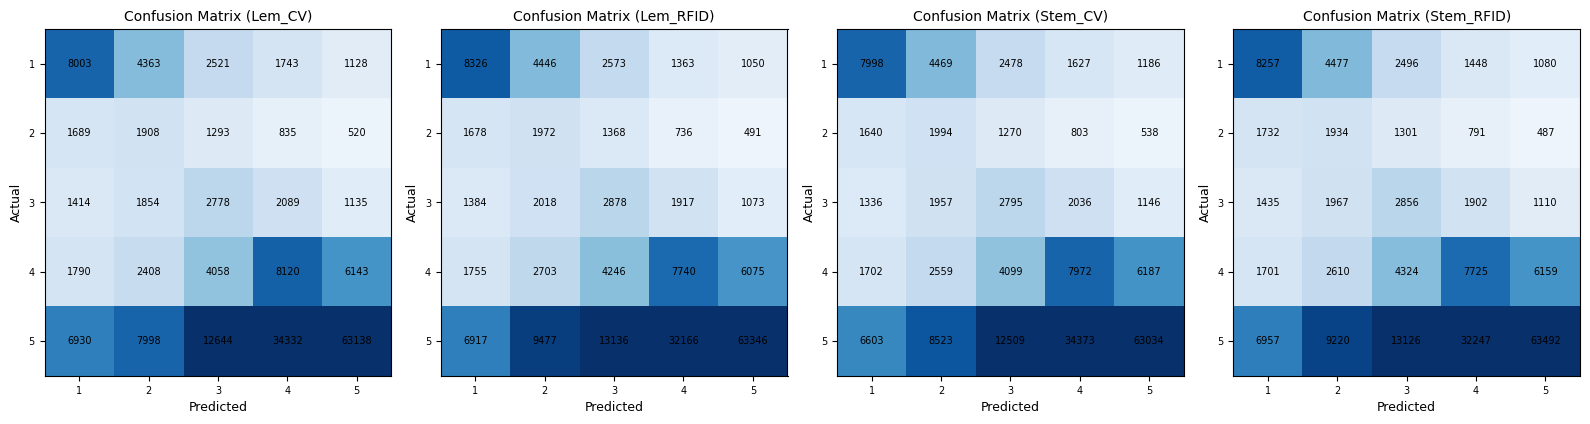

Lem_CV: Train Accuracy - 0.9615, Test Accuracy - 0.4642
Lem_TFIDF: Train Accuracy - 0.9615, Test Accuracy - 0.4660
Stem_CV: Train Accuracy - 0.9594, Test Accuracy - 0.4634
Stem_TFIDF: Train Accuracy - 0.9594, Test Accuracy - 0.4660


In [102]:
combinations = ['Lem_CV', 'Lem_RFID', 'Stem_CV', 'Stem_RFID']

plt.figure(figsize=(16, 4))

for i, combination in enumerate(combinations, 1):
    plt.subplot(1, 4, i)
    
    # Get y_test and y_pred_test for the current combination
    y_test_comb = globals()[f"y_test"]
    y_pred_test_comb = globals()[f"y_pred_test_dt_{combination.lower()}"]
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test_comb, y_pred_test_comb)

    print(cm)
    
    # Plotting Confusion Matrix using imshow
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 10000)
    
    # Adding annotations
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)
    
    plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
    plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
    plt.title(f'Confusion Matrix ({combination})', fontsize=10)
    plt.xlabel('Predicted', fontsize=9)
    plt.ylabel('Actual', fontsize=9)

plt.tight_layout()
# plt.savefig('../../images/DTUSConfMatrix.png')
plt.show()

accuracy_scores = {
    'Lem_CV': {'Train': accuracy_train_dt_lem_cv, 'Test': accuracy_test_dt_lem_cv},
    'Lem_TFIDF': {'Train': accuracy_train_dt_lem_rfid, 'Test': accuracy_test_dt_lem_rfid},
    'Stem_CV': {'Train': accuracy_train_dt_stem_cv, 'Test': accuracy_test_dt_stem_cv},
    'Stem_TFIDF': {'Train': accuracy_train_dt_stem_rfid, 'Test': accuracy_test_dt_stem_rfid},
}

# Sorting based on the test accuracy
sorted_accuracy_scores = sorted(accuracy_scores.items(), key=lambda x: x[1]['Train'], reverse=True)

# Displaying the sorted results
for combination, scores in sorted_accuracy_scores:
    print(f"{combination}: Train Accuracy - {scores['Train']:.4f}, Test Accuracy - {scores['Test']:.4f}")

### Best DT Classification

In [20]:
# Best DT Classification Model

# Best results achieved without Sampling
best_dt_train_tokens = column_lemmatizer(X_train_nosample)
best_dt_test_tokens = column_lemmatizer(X_test)

best_dt_train_vectors, best_dt_test_vectors = count_vectorize_data(best_dt_train_tokens, best_dt_test_tokens)

# best_logistic_train_sampled = 

scaler = MaxAbsScaler()
best_dt_train_scaled = scaler.fit_transform(best_dt_train_vectors)
best_dt_test_scaled = scaler.transform(best_dt_test_vectors)

print('preprocessing complete')

best_dt_model = DecisionTreeClassifier()
best_dt_model.fit(best_dt_train_scaled, y_train_nosample)

print('model fitted')

y_pred_train_dt_best = best_dt_model.predict(best_dt_train_scaled)
print('train predicted')

y_pred_test_dt_best = best_dt_model.predict(best_dt_test_scaled)
print('train predicted')

accuracy_train_dt_best = accuracy_score(y_train_nosample, y_pred_train_dt_best)
precision_train_dt_best = precision_score(y_train_nosample, y_pred_train_dt_best, average='weighted')
recall_train_dt_best = recall_score(y_train_nosample, y_pred_train_dt_best, average='weighted')
f1_train_dt_best = f1_score(y_train_nosample, y_pred_train_dt_best, average='weighted')
r2_train_dt_best = r2_score(y_train_nosample, y_pred_train_dt_best)
mse_train_dt_best = mean_squared_error(y_train_nosample, y_pred_train_dt_best)

accuracy_test_dt_best = accuracy_score(y_test, y_pred_test_dt_best)
precision_test_dt_best = precision_score(y_test, y_pred_test_dt_best, average='weighted')
recall_test_dt_best = recall_score(y_test, y_pred_test_dt_best, average='weighted')
f1_test_dt_best = f1_score(y_test, y_pred_test_dt_best, average='weighted')
r2_test_dt_best = r2_score(y_test, y_pred_test_dt_best)
mse_test_dt_best = mean_squared_error(y_test, y_pred_test_dt_best)

print('Train Results')
print("Accuracy Score: Decision Tree Classification Train Data (lem - CV):", accuracy_train_dt_best)
print("Precision Score: Decision Tree Classification Train Data (lem - CV):", precision_train_dt_best)
print("Recall Score: Decision Tree Classification Data (lem - CV):", recall_train_dt_best)
print("F1 Score: Decision Tree Classification Train Data (lem - CV):", f1_train_dt_best)
print("R Squared Score: Decision Tree Classification Train Data (lem - CV):", r2_train_dt_best)
print("Mean Squared Error Score: Decision Tree Classification Train Data (lem - CV):", mse_train_dt_best)
print()
print('Test Results')
print("Accuracy Score: Decision Tree Classification Test Data (lem - CV):", accuracy_test_dt_best)
print("Precision Score: Decision Tree Classification Test Data (lem - CV):", precision_test_dt_best)
print("Recall Score: Decision Tree Classification Test Data (lem - CV):", recall_test_dt_best)
print("F1 Score: Decision Tree Classification Test Data (lem - CV):", f1_test_dt_best)
print("R Squared Score: Decision Tree Classification Test Data (lem - CV):", r2_test_dt_best)
print("Mean Squared Error Score: Decision Tree Classification Test Data (lem - CV):", mse_test_dt_best)

preprocessing complete
model fitted
train predicted
train predicted
Train Results
Accuracy Score: Decision Tree Classification Train Data (lem - CV): 0.9706713940034555
Precision Score: Decision Tree Classification Train Data (lem - CV): 0.9710051197424993
Recall Score: Decision Tree Classification Data (lem - CV): 0.9706713940034555
F1 Score: Decision Tree Classification Train Data (lem - CV): 0.9699458623659563
R Squared Score: Decision Tree Classification Train Data (lem - CV): 0.9549873359389643
Mean Squared Error Score: Decision Tree Classification Train Data (lem - CV): 0.0763728750091837

Test Results
Accuracy Score: Decision Tree Classification Test Data (lem - CV): 0.6834500149308206
Precision Score: Decision Tree Classification Test Data (lem - CV): 0.6632949011084746
Recall Score: Decision Tree Classification Test Data (lem - CV): 0.6834500149308206
F1 Score: Decision Tree Classification Test Data (lem - CV): 0.6726694493688051
R Squared Score: Decision Tree Classification T

[[ 41101     48     20     14    686]
 [   203  14033     18      7    228]
 [   129     71  20003     45   1134]
 [    66     27    114  44377   8373]
 [   170     29    121    872 290054]]
[[  9402   1546   1186   1289   4335]
 [  1964    820    740    743   1978]
 [  1446    637   1724   1607   3856]
 [  1300    562   1280   4950  14427]
 [  3686   1405   2745  10511 106695]]


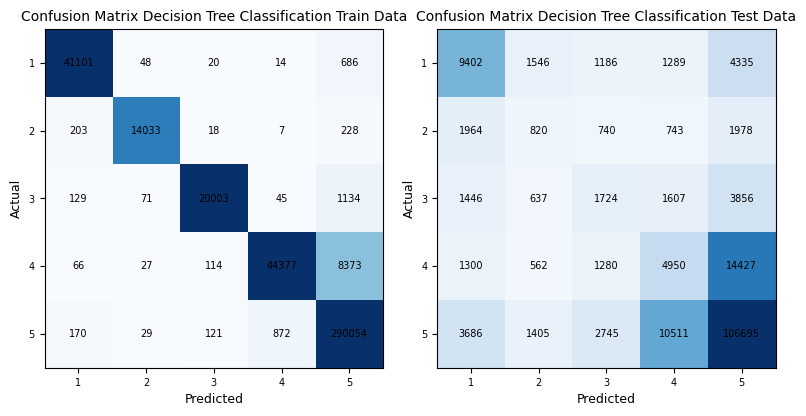

In [30]:
# Calculate confusion matrix
plt.figure(figsize=(8, 4))

# Calculate confusion matrix
cm = confusion_matrix(y_train_nosample, y_pred_train_dt_best)

print(cm)

# Plotting Confusion Matrix using imshow
plt.subplot(1, 2, 1)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 20000)

# Adding annotations
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)

plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.xlabel('Predicted', fontsize=9)
plt.ylabel('Actual', fontsize=9)
plt.title(f'Confusion Matrix Decision Tree Classification Train Data', fontsize=10)

cm = confusion_matrix(y_test, y_pred_test_dt_best)

print(cm)
plt.subplot(1, 2, 2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 20000)

# Adding annotations
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)

plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.xlabel('Predicted', fontsize=9)
plt.ylabel('Actual', fontsize=9)

plt.title(f'Confusion Matrix Decision Tree Classification Test Data', fontsize=10)
plt.tight_layout()
# plt.savefig('../../images/DTBestConfMatrix.png')
plt.show()

# 5. Random Forest Classifier

In [40]:
# a) Random Forest on Lemmatized CountVectorized data

# Random Forest model
rf_model = RandomForestClassifier(n_jobs=-1)  # You can customize parameters here if needed
rf_model.fit(X_lem_CV_train, y_train)
y_pred_train_rf_lem_cv = rf_model.predict(X_lem_CV_train)
y_pred_test_rf_lem_cv = rf_model.predict(X_lem_CV_test)

# Random Forest classification reports and accuracy scores
rf_report_train_lem_cv_imbalanced = classification_report_imbalanced(y_train, y_pred_train_rf_lem_cv)
rf_report_test_lem_cv_imbalanced = classification_report_imbalanced(y_test, y_pred_test_rf_lem_cv)
accuracy_train_rf_lem_cv = accuracy_score(y_train, y_pred_train_rf_lem_cv)
accuracy_test_rf_lem_cv = accuracy_score(y_test, y_pred_test_rf_lem_cv)

# Print results
print("Random Forest - Classification Report: Train Data (lem_cv):\n", rf_report_train_lem_cv_imbalanced)
print("\nRandom Forest - Classification Report: Test Data (lem_cv):\n", rf_report_test_lem_cv_imbalanced)
print("\nAccuracy Score: Train Data (lem_cv):", accuracy_train_rf_lem_cv)
print("Accuracy Score: Test Data (lem_cv):", accuracy_test_rf_lem_cv)


Random Forest - Classification Report: Train Data (lem_cv):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.98      0.98      1.00      0.98      0.99      0.98     14489
          2       0.99      0.98      1.00      0.98      0.99      0.98     14489
          3       0.98      0.96      1.00      0.97      0.98      0.95     14489
          4       0.92      0.94      0.98      0.93      0.96      0.91     14489
          5       0.93      0.95      0.98      0.94      0.97      0.93     14489

avg / total       0.96      0.96      0.99      0.96      0.98      0.95     72445


Random Forest - Classification Report: Test Data (lem_cv):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.51      0.65      0.93      0.57      0.78      0.59     17758
          2       0.13      0.34      0.92      0.19      0.56      0.29      6245
          3       0.19      0.34      0.92  

In [41]:
# b) Random Forest on Lemmatized TFIDFVectorized data

# Random Forest model
rf_model = RandomForestClassifier(n_jobs=-1)  # You can customize parameters here if needed
rf_model.fit(X_lem_RFID_train, y_train)
y_pred_train_rf_lem_rfid = rf_model.predict(X_lem_RFID_train)
y_pred_test_rf_lem_rfid = rf_model.predict(X_lem_RFID_test)

# Random Forest classification reports and accuracy scores
rf_report_train_lem_rfid_imbalanced = classification_report_imbalanced(y_train, y_pred_train_rf_lem_rfid)
rf_report_test_lem_rfid_imbalanced = classification_report_imbalanced(y_test, y_pred_test_rf_lem_rfid)
accuracy_train_rf_lem_rfid = accuracy_score(y_train, y_pred_train_rf_lem_rfid)
accuracy_test_rf_lem_rfid = accuracy_score(y_test, y_pred_test_rf_lem_rfid)

# Print results
print("Random Forest - Classification Report: Train Data (lem_tfidf):\n", rf_report_train_lem_rfid_imbalanced)
print("\nRandom Forest - Classification Report: Test Data (lem_tfidf):\n", rf_report_test_lem_rfid_imbalanced)
print("\nAccuracy Score: Train Data (lem_tfidf):", accuracy_train_rf_lem_rfid)
print("Accuracy Score: Test Data (lem_tfidf):", accuracy_test_rf_lem_rfid)

Random Forest - Classification Report: Train Data (lem_tfidf):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.98      0.98      1.00      0.98      0.99      0.98     14489
          2       0.99      0.98      1.00      0.98      0.99      0.97     14489
          3       0.98      0.96      1.00      0.97      0.98      0.95     14489
          4       0.92      0.94      0.98      0.93      0.96      0.91     14489
          5       0.93      0.95      0.98      0.94      0.97      0.93     14489

avg / total       0.96      0.96      0.99      0.96      0.98      0.95     72445


Random Forest - Classification Report: Test Data (lem_tfidf):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.48      0.68      0.92      0.56      0.79      0.61     17758
          2       0.12      0.34      0.91      0.18      0.56      0.30      6245
          3       0.18      0.36      

In [42]:
# c) Random Forest on Stemmatized CountVectorized data

# Random Forest model
rf_model = RandomForestClassifier(n_jobs=-1)  # You can customize parameters here if needed
rf_model.fit(X_stem_CV_train, y_train)
y_pred_train_rf_stem_cv = rf_model.predict(X_stem_CV_train)
y_pred_test_rf_stem_cv = rf_model.predict(X_stem_CV_test)

# Random Forest classification reports and accuracy scores
rf_report_train_stem_cv_imbalanced = classification_report_imbalanced(y_train, y_pred_train_rf_stem_cv)
rf_report_test_stem_cv_imbalanced = classification_report_imbalanced(y_test, y_pred_test_rf_stem_cv)
accuracy_train_rf_stem_cv = accuracy_score(y_train, y_pred_train_rf_stem_cv)
accuracy_test_rf_stem_cv = accuracy_score(y_test, y_pred_test_rf_stem_cv)

# Print results
print("Random Forest - Classification Report: Train Data (stem_cv):\n", rf_report_train_stem_cv_imbalanced)
print("\nRandom Forest - Classification Report: Test Data (stem_cv):\n", rf_report_test_stem_cv_imbalanced)
print("\nAccuracy Score: Train Data (stem_cv):", accuracy_train_rf_stem_cv)
print("Accuracy Score: Test Data (stem_cv):", accuracy_test_rf_stem_cv)

Random Forest - Classification Report: Train Data (stem_cv):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.98      0.98      1.00      0.98      0.99      0.98     14489
          2       0.99      0.98      1.00      0.98      0.99      0.97     14489
          3       0.98      0.96      1.00      0.97      0.98      0.95     14489
          4       0.92      0.93      0.98      0.92      0.96      0.91     14489
          5       0.93      0.94      0.98      0.94      0.96      0.92     14489

avg / total       0.96      0.96      0.99      0.96      0.97      0.95     72445


Random Forest - Classification Report: Test Data (stem_cv):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.49      0.65      0.93      0.56      0.78      0.59     17758
          2       0.13      0.34      0.92      0.19      0.56      0.29      6245
          3       0.18      0.34      0.92

In [43]:
# d) Random Forest on Stemmatized TFIDFVectorized data

# Random Forest model
rf_model = RandomForestClassifier(n_jobs=-1)  # You can customize parameters here if needed
rf_model.fit(X_stem_RFID_train, y_train)
y_pred_train_rf_stem_rfid = rf_model.predict(X_stem_RFID_train)
y_pred_test_rf_stem_rfid = rf_model.predict(X_stem_RFID_test)

# Random Forest classification reports and accuracy scores
rf_report_train_stem_rfid_imbalanced = classification_report_imbalanced(y_train, y_pred_train_rf_stem_rfid)
rf_report_test_stem_rfid_imbalanced = classification_report_imbalanced(y_test, y_pred_test_rf_stem_rfid)
accuracy_train_rf_stem_rfid = accuracy_score(y_train, y_pred_train_rf_stem_rfid)
accuracy_test_rf_stem_rfid = accuracy_score(y_test, y_pred_test_rf_stem_rfid)

# Print results
print("Random Forest - Classification Report: Train Data (stem_tfidf):\n", rf_report_train_stem_rfid_imbalanced)
print("\nRandom Forest - Classification Report: Test Data (stem_tfidf):\n", rf_report_test_stem_rfid_imbalanced)
print("\nAccuracy Score: Train Data (stem_tfidf):", accuracy_train_rf_stem_rfid)
print("Accuracy Score: Test Data (stem_tfidf):", accuracy_test_rf_stem_rfid)

Random Forest - Classification Report: Train Data (stem_tfidf):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.98      0.98      1.00      0.98      0.99      0.98     14489
          2       0.99      0.98      1.00      0.98      0.99      0.97     14489
          3       0.98      0.96      1.00      0.97      0.98      0.95     14489
          4       0.92      0.93      0.98      0.92      0.96      0.91     14489
          5       0.93      0.95      0.98      0.94      0.96      0.93     14489

avg / total       0.96      0.96      0.99      0.96      0.97      0.95     72445


Random Forest - Classification Report: Test Data (stem_tfidf):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.48      0.68      0.92      0.56      0.79      0.61     17758
          2       0.12      0.34      0.91      0.18      0.55      0.29      6245
          3       0.17      0.36    

## Summary - Random Forest

In [44]:
# a) Lemmatized CountVectorized data
rf_report_train_lem_cv_imbalanced_last = [accuracy_train_rf_lem_cv*100] + [float(value) for value in rf_report_train_lem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
rf_report_test_lem_cv_imbalanced_last = [accuracy_test_rf_lem_cv*100] + [float(value) for value in rf_report_test_lem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_rf_report_lem_cv_imbalanced = pd.DataFrame([rf_report_train_lem_cv_imbalanced_last, rf_report_test_lem_cv_imbalanced_last], columns=column_names)
final_rf_report_lem_cv_imbalanced['Data Type'] = ['Lemmatized Count Vectorized', 'Lemmatized Count Vectorized']
final_rf_report_lem_cv_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_rf_report_lem_cv_imbalanced.set_index('Data Type', inplace=True)
final_rf_report_lem_cv_imbalanced.index.name = None

# Reorder columns
final_rf_report_lem_cv_imbalanced = final_rf_report_lem_cv_imbalanced[['Train/Test'] + column_names]


# b) Lemmatized TFIDFVectorized data
rf_report_train_lem_rfid_imbalanced_last = [accuracy_train_rf_lem_rfid*100] + [float(value) for value in rf_report_train_lem_rfid_imbalanced.split()[-7:]] # Extracting the last 6 values
rf_report_test_lem_rfid_imbalanced_last = [accuracy_test_rf_lem_rfid*100] + [float(value) for value in rf_report_test_lem_rfid_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_rf_report_lem_rfid_imbalanced = pd.DataFrame([rf_report_train_lem_rfid_imbalanced_last, rf_report_test_lem_rfid_imbalanced_last], columns=column_names)
final_rf_report_lem_rfid_imbalanced['Data Type'] = ['Lemmatized TFIDF Vectorized', 'Lemmatized TFIDF Vectorized']
final_rf_report_lem_rfid_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_rf_report_lem_rfid_imbalanced.set_index('Data Type', inplace=True)
final_rf_report_lem_rfid_imbalanced.index.name = None

# Reorder columns
final_rf_report_lem_rfid_imbalanced = final_rf_report_lem_rfid_imbalanced[['Train/Test'] + column_names]


# c) Stemmatized CountVectorized data
rf_report_train_stem_cv_imbalanced_last = [accuracy_train_rf_stem_cv*100] + [float(value) for value in rf_report_train_stem_cv_imbalanced.split()[-7:]] # Extracting the last 6 values
rf_report_test_stem_cv_imbalanced_last = [accuracy_test_rf_stem_cv*100] + [float(value) for value in rf_report_test_stem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_rf_report_stem_cv_imbalanced = pd.DataFrame([rf_report_train_stem_cv_imbalanced_last, rf_report_test_stem_cv_imbalanced_last], columns=column_names)
final_rf_report_stem_cv_imbalanced['Data Type'] = ['Stemmatized Count Vectorized', 'Stemmatized Count Vectorized']
final_rf_report_stem_cv_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_rf_report_stem_cv_imbalanced.set_index('Data Type', inplace=True)
final_rf_report_stem_cv_imbalanced.index.name = None

# Reorder columns
final_rf_report_stem_cv_imbalanced = final_rf_report_stem_cv_imbalanced[['Train/Test'] + column_names]


# d) Stemmatized TFIDFVectorized data
rf_report_train_stem_rfid_imbalanced_last = [accuracy_train_rf_stem_rfid*100]+ [float(value) for value in rf_report_train_stem_rfid_imbalanced.split()[-7:]] # Extracting the last 6 values
rf_report_test_stem_rfid_imbalanced_last = [accuracy_test_rf_stem_rfid*100] + [float(value) for value in rf_report_test_stem_rfid_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_rf_report_stem_rfid_imbalanced = pd.DataFrame([rf_report_train_stem_rfid_imbalanced_last, rf_report_test_stem_rfid_imbalanced_last], columns=column_names)
final_rf_report_stem_rfid_imbalanced['Data Type'] = ['Stemmatized TFIDF Vectorized', 'Stemmatized TFIDF Vectorized']
final_rf_report_stem_rfid_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_rf_report_stem_rfid_imbalanced.set_index('Data Type', inplace=True)
final_rf_report_stem_rfid_imbalanced.index.name = None

# Reorder columns
final_rf_report_stem_rfid_imbalanced = final_rf_report_stem_rfid_imbalanced[['Train/Test'] + column_names]

### Averaged classification report for Random Forest

In [45]:
final_rf_report = pd.concat([final_rf_report_lem_cv_imbalanced,
                    final_rf_report_lem_rfid_imbalanced,
                    final_rf_report_stem_cv_imbalanced,
                    final_rf_report_stem_rfid_imbalanced])

final_rf_report.head(8)

,Train/Test,Accuracy,Precision,Recall,Specificity,F1-Score,Geometric Mean,Index Balanced Accuracy (IBA),Support
Lemmatized Count Vectorized,Train,96.148803,0.96,0.96,0.99,0.96,0.98,0.95,72445.0
Lemmatized Count Vectorized,Test,57.721446,0.71,0.58,0.85,0.62,0.70,0.48,180834.0
Lemmatized TFIDF Vectorized,Train,96.144661,0.96,0.96,0.99,0.96,0.98,0.95,72445.0
Lemmatized TFIDF Vectorized,Test,57.045688,0.71,0.57,0.86,0.62,0.70,0.48,180834.0
Stemmatized Count Vectorized,Train,95.943129,0.96,0.96,0.99,0.96,0.97,0.95,72445.0
Stemmatized Count Vectorized,Test,56.789099,0.71,0.57,0.86,0.62,0.69,0.47,180834.0
Stemmatized TFIDF Vectorized,Train,95.938988,0.96,0.96,0.99,0.96,0.97,0.95,72445.0
Stemmatized TFIDF Vectorized,Test,56.597211,0.71,0.57,0.86,0.61,0.70,0.48,180834.0


### Confusion Matrix for Random Forest

[[11587  3506  1279   743   643]
 [ 2217  2101  1150   449   328]
 [ 1475  2004  3111  1790   890]
 [ 1426  2085  3756  8355  6897]
 [ 5948  5984  7387 26497 79226]]
[[12053  3319  1345   544   497]
 [ 2332  2144  1196   328   245]
 [ 1560  2122  3359  1432   797]
 [ 1662  2524  4351  7396  6586]
 [ 7453  7480  8776 23127 78206]]
[[11631  3506  1273   794   554]
 [ 2240  2120  1101   490   294]
 [ 1516  1965  3137  1801   851]
 [ 1522  2198  3811  8310  6678]
 [ 6679  6314  7657 26896 77496]]
[[11987  3385  1322   566   498]
 [ 2356  2106  1181   351   251]
 [ 1575  2107  3370  1449   769]
 [ 1651  2471  4370  7525  6502]
 [ 7632  7328  9277 23446 77359]]


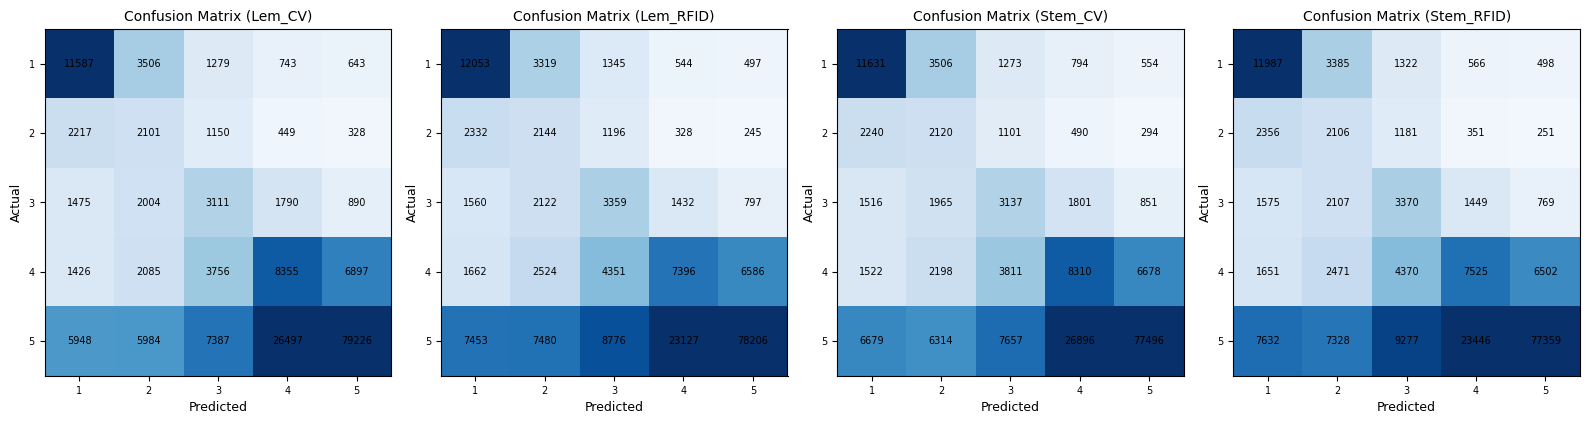

Lem_CV: Train Accuracy - 0.9615, Test Accuracy - 0.5772
Lem_TFIDF: Train Accuracy - 0.9614, Test Accuracy - 0.5705
Stem_CV: Train Accuracy - 0.9594, Test Accuracy - 0.5679
Stem_TFIDF: Train Accuracy - 0.9594, Test Accuracy - 0.5660


In [101]:
combinations = ['Lem_CV', 'Lem_RFID', 'Stem_CV', 'Stem_RFID']

plt.figure(figsize=(16, 4))

for i, combination in enumerate(combinations, 1):
    plt.subplot(1, 4, i)
    
    # Get y_test and y_pred_test for the current combination
    y_test_comb = globals()[f"y_test"]
    y_pred_test_comb = globals()[f"y_pred_test_rf_{combination.lower()}"]
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test_comb, y_pred_test_comb)

    print(cm)
    
    # Plotting Confusion Matrix using imshow
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 10000)
    
    # Adding annotations
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)
    
    plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
    plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
    plt.title(f'Confusion Matrix ({combination})', fontsize=10)
    plt.xlabel('Predicted', fontsize=9)
    plt.ylabel('Actual', fontsize=9)

plt.tight_layout()
# plt.savefig('../../images/RFUSConfMatrix.png')
plt.show()

accuracy_scores = {
    'Lem_CV': {'Train': accuracy_train_rf_lem_cv, 'Test': accuracy_test_rf_lem_cv},
    'Lem_TFIDF': {'Train': accuracy_train_rf_lem_rfid, 'Test': accuracy_test_rf_lem_rfid},
    'Stem_CV': {'Train': accuracy_train_rf_stem_cv, 'Test': accuracy_test_rf_stem_cv},
    'Stem_TFIDF': {'Train': accuracy_train_rf_stem_rfid, 'Test': accuracy_test_rf_stem_rfid},
}

# Sorting based on the test accuracy
sorted_accuracy_scores = sorted(accuracy_scores.items(), key=lambda x: x[1]['Train'], reverse=True)

# Displaying the sorted results
for combination, scores in sorted_accuracy_scores:
    print(f"{combination}: Train Accuracy - {scores['Train']:.4f}, Test Accuracy - {scores['Test']:.4f}")

### Best RF Model

In [13]:
# Best RF Classification Model

# Best results achieved without Sampling
best_rf_train_tokens = new_column_lemmatizer(X_train_nosample)
print('train complete')

best_rf_test_tokens = new_column_lemmatizer(X_test)
print('test complete')

best_rf_train_vectors, best_rf_test_vectors = new_count_vectorize_data(best_rf_train_tokens, best_rf_test_tokens)


train complete
test complete


In [10]:
# best_logistic_train_sampled = 

In [14]:
best_rf_model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, n_jobs=-1)
best_rf_model.fit(best_rf_train_vectors, y_train_nosample)


RandomForestClassifier(n_estimators=200, n_jobs=-1)

In [15]:
with open('../../../models/classification/RFBestModel.pkl', 'wb') as file:
    pickle.dump(best_rf_model, file)

print('model fitted')

model fitted


In [16]:
y_pred_train_rf_best = best_rf_model.predict(best_rf_train_vectors)
print('train predicted')

y_pred_test_rf_best = best_rf_model.predict(best_rf_test_vectors)
print('test predicted')

print(best_rf_test_vectors.shape)
print(best_rf_test_vectors.shape)

accuracy_train_rf_best = accuracy_score(y_train_nosample, y_pred_train_rf_best)
precision_train_rf_best = precision_score(y_train_nosample, y_pred_train_rf_best, average='weighted')
recall_train_rf_best = recall_score(y_train_nosample, y_pred_train_rf_best, average='weighted')
f1_train_rf_best = f1_score(y_train_nosample, y_pred_train_rf_best, average='weighted')
r2_train_rf_best = r2_score(y_train_nosample, y_pred_train_rf_best)
mse_train_rf_best = mean_squared_error(y_train_nosample, y_pred_train_rf_best)

accuracy_test_rf_best = accuracy_score(y_test, y_pred_test_rf_best)
precision_test_rf_best = precision_score(y_test, y_pred_test_rf_best, average='weighted')
recall_test_rf_best = recall_score(y_test, y_pred_test_rf_best, average='weighted')
f1_test_rf_best = f1_score(y_test, y_pred_test_rf_best, average='weighted')
r2_test_rf_best = r2_score(y_test, y_pred_test_rf_best)
mse_test_rf_best = mean_squared_error(y_test, y_pred_test_rf_best)

print('Train Results')
print("Accuracy Score: Random Forest Classification Train Data (lem - CV):", accuracy_train_rf_best)
print("Precision Score: Random Forest Classification Train Data (lem - CV):", precision_train_rf_best)
print("Recall Score: Random Forest Classification Train Data (lem - CV):", recall_train_rf_best)
print("F1 Score: Random Forest Classification Train Data (lem - CV):", f1_train_rf_best)
print("R Squared Score: Random Forest Classification Train Data (lem - CV):", r2_train_rf_best)
print("Mean Squared Error Score: Random Forest Classification Train Data (lem - CV):", mse_train_rf_best)
print()
print('Test Results')
print("Accuracy Score: Random Forest Classification Test Data (lem - CV):", accuracy_test_rf_best)
print("Precision Score: Random Forest Classification Test Data (lem - CV):", precision_test_rf_best)
print("Recall Score: Random Forest Classification Test Data (lem - CV):", recall_test_rf_best)
print("F1 Score: Random Forest Classification Test Data (lem - CV):", f1_test_rf_best)
print("R Squared Score: Random Forest Classification Test Data (lem - CV):", r2_test_rf_best)
print("Mean Squared Error Score: Random Forest Classification Test Data (lem - CV):", mse_test_rf_best)

train predicted
test predicted
(180834, 28822)
(180834, 28822)
Train Results
Accuracy Score: Random Forest Classification Train Data (lem - CV): 0.9660688766018158
Precision Score: Random Forest Classification Train Data (lem - CV): 0.9669864238066247
Recall Score: Random Forest Classification Train Data (lem - CV): 0.9660688766018158
F1 Score: Random Forest Classification Train Data (lem - CV): 0.9649300329678066
R Squared Score: Random Forest Classification Train Data (lem - CV): 0.9486611185446299
Mean Squared Error Score: Random Forest Classification Train Data (lem - CV): 0.08710655230682818

Test Results
Accuracy Score: Random Forest Classification Test Data (lem - CV): 0.7539124279726158
Precision Score: Random Forest Classification Test Data (lem - CV): 0.6980850027217274
Recall Score: Random Forest Classification Test Data (lem - CV): 0.7539124279726158
F1 Score: Random Forest Classification Test Data (lem - CV): 0.6885483674284165
R Squared Score: Random Forest Classification

[[ 40993     69     34     28    745]
 [   179  14018     33     12    247]
 [    98     60  19946     78   1200]
 [    45     20     79  43807   9006]
 [   104     13     55    270 290804]]
[[ 10132    185    133     95   7213]
 [  1778    316    122    112   3917]
 [   919    104    784    422   7041]
 [   403     28    166   1664  20258]
 [   650     67    165    921 123239]]


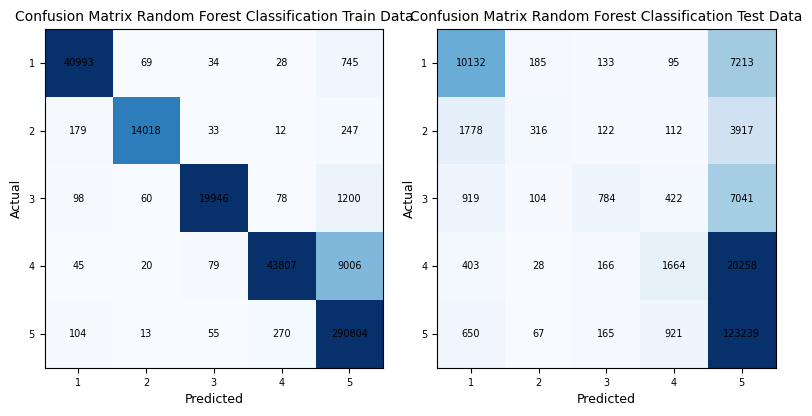

In [31]:
# Calculate confusion matrix
plt.figure(figsize=(8, 4))

# Calculate confusion matrix
cm = confusion_matrix(y_train_nosample, y_pred_train_rf_best)

print(cm)

# Plotting Confusion Matrix using imshow
plt.subplot(1, 2, 1)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 20000)

# Adding annotations
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)

plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.xlabel('Predicted', fontsize=9)
plt.ylabel('Actual', fontsize=9)
plt.title(f'Confusion Matrix Random Forest Classification Train Data', fontsize=10)

cm = confusion_matrix(y_test, y_pred_test_rf_best)

print(cm)
plt.subplot(1, 2, 2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 20000)

# Adding annotations
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)

plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.xlabel('Predicted', fontsize=9)
plt.ylabel('Actual', fontsize=9)

plt.title(f'Confusion Matrix Random Forest Classification Test Data', fontsize=10)
plt.tight_layout()
# plt.savefig('../../images/RFBestConfMatrix.png')
plt.show()

# 6. Naive Bayes

In [47]:
# a) Naive Bayes on Lemmatized CountVectorized data

# Naive Bayes model
nb_model = MultinomialNB()  # You can customize parameters here if needed
nb_model.fit(X_lem_CV_train, y_train)
y_pred_train_nb_lem_cv = nb_model.predict(X_lem_CV_train)
y_pred_test_nb_lem_cv = nb_model.predict(X_lem_CV_test)

# Naive Bayes classification reports and accuracy scores
nb_report_train_lem_cv_imbalanced = classification_report_imbalanced(y_train, y_pred_train_nb_lem_cv)
nb_report_test_lem_cv_imbalanced = classification_report_imbalanced(y_test, y_pred_test_nb_lem_cv)
accuracy_train_nb_lem_cv = accuracy_score(y_train, y_pred_train_nb_lem_cv)
accuracy_test_nb_lem_cv = accuracy_score(y_test, y_pred_test_nb_lem_cv)

# Print results
print("Naive Bayes - Classification Report: Train Data (lem_cv):\n", nb_report_train_lem_cv_imbalanced)
print("\nNaive Bayes - Classification Report: Test Data (lem_cv):\n", nb_report_test_lem_cv_imbalanced)
print("\nAccuracy Score: Train Data (lem_cv):", accuracy_train_nb_lem_cv)
print("Accuracy Score: Test Data (lem_cv):", accuracy_test_nb_lem_cv)

Naive Bayes - Classification Report: Train Data (lem_cv):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.58      0.66      0.88      0.62      0.77      0.57     14489
          2       0.51      0.44      0.89      0.47      0.62      0.37     14489
          3       0.51      0.45      0.89      0.48      0.63      0.38     14489
          4       0.51      0.38      0.91      0.44      0.59      0.33     14489
          5       0.56      0.78      0.85      0.65      0.81      0.65     14489

avg / total       0.54      0.54      0.89      0.53      0.68      0.46     72445


Naive Bayes - Classification Report: Test Data (lem_cv):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.51      0.61      0.94      0.55      0.76      0.55     17758
          2       0.14      0.32      0.93      0.19      0.55      0.28      6245
          3       0.20      0.35      0.92      

In [48]:
# b) Naive Bayes on Lemmatized TFIDFVectorized data

# Naive Bayes model
nb_model = MultinomialNB()  # You can customize parameters here if needed
nb_model.fit(X_lem_RFID_train, y_train)
y_pred_train_nb_lem_rfid = nb_model.predict(X_lem_RFID_train)
y_pred_test_nb_lem_rfid = nb_model.predict(X_lem_RFID_test)

# Naive Bayes classification reports and accuracy scores
nb_report_train_lem_rfid_imbalanced = classification_report_imbalanced(y_train, y_pred_train_nb_lem_rfid)
nb_report_test_lem_rfid_imbalanced = classification_report_imbalanced(y_test, y_pred_test_nb_lem_rfid)
accuracy_train_nb_lem_rfid = accuracy_score(y_train, y_pred_train_nb_lem_rfid)
accuracy_test_nb_lem_rfid = accuracy_score(y_test, y_pred_test_nb_lem_rfid)

# Print results
print("Naive Bayes - Classification Report: Train Data (lem_tfidf):\n", nb_report_train_lem_rfid_imbalanced)
print("\nNaive Bayes - Classification Report: Test Data (lem_tfidf):\n", nb_report_test_lem_rfid_imbalanced)
print("\nAccuracy Score: Train Data (lem_tfidf):", accuracy_train_nb_lem_rfid)
print("Accuracy Score: Test Data (lem_tfidf):", accuracy_test_nb_lem_rfid)

Naive Bayes - Classification Report: Train Data (lem_tfidf):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.59      0.71      0.88      0.64      0.79      0.61     14489
          2       0.51      0.51      0.88      0.51      0.67      0.43     14489
          3       0.51      0.51      0.88      0.51      0.67      0.43     14489
          4       0.55      0.40      0.92      0.46      0.60      0.34     14489
          5       0.63      0.67      0.90      0.65      0.78      0.59     14489

avg / total       0.56      0.56      0.89      0.55      0.70      0.48     72445


Naive Bayes - Classification Report: Test Data (lem_tfidf):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.49      0.64      0.93      0.55      0.77      0.57     17758
          2       0.12      0.36      0.91      0.18      0.57      0.31      6245
          3       0.17      0.40      0.89

In [22]:
# c) Naive Bayes on Stemmatized CountVectorized data

# Naive Bayes model
nb_model = MultinomialNB()  # You can customize parameters here if needed
nb_model.fit(X_stem_CV_train, y_train)
y_pred_train_nb_stem_cv = nb_model.predict(X_stem_CV_train)
y_pred_test_nb_stem_cv = nb_model.predict(X_stem_CV_test)

# Naive Bayes classification reports and accuracy scores
nb_report_train_stem_cv_imbalanced = classification_report_imbalanced(y_train, y_pred_train_nb_stem_cv)
nb_report_test_stem_cv_imbalanced = classification_report_imbalanced(y_test, y_pred_test_nb_stem_cv)
accuracy_train_nb_stem_cv = accuracy_score(y_train, y_pred_train_nb_stem_cv)
accuracy_test_nb_stem_cv = accuracy_score(y_test, y_pred_test_nb_stem_cv)

# Print results
print("Naive Bayes - Classification Report: Train Data (stem_cv):\n", nb_report_train_stem_cv_imbalanced)
print("\nNaive Bayes - Classification Report: Test Data (stem_cv):\n", nb_report_test_stem_cv_imbalanced)
print("\nAccuracy Score: Train Data (stem_cv):", accuracy_train_nb_stem_cv)
print("Accuracy Score: Test Data (stem_cv):", accuracy_test_nb_stem_cv)

Naive Bayes - Classification Report: Train Data (stem_cv):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.58      0.63      0.89      0.60      0.74      0.54     14489
          2       0.48      0.43      0.88      0.45      0.61      0.36     14489
          3       0.49      0.43      0.89      0.45      0.61      0.36     14489
          4       0.49      0.37      0.90      0.42      0.58      0.32     14489
          5       0.55      0.76      0.84      0.64      0.80      0.64     14489

avg / total       0.52      0.52      0.88      0.51      0.67      0.44     72445


Naive Bayes - Classification Report: Test Data (stem_cv):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.51      0.58      0.94      0.54      0.74      0.53     17758
          2       0.14      0.34      0.92      0.20      0.56      0.30      6245
          3       0.20      0.35      0.92    

In [50]:
# d) Naive Bayes on Lemmatized TFIDFVectorized data

# Naive Bayes model
nb_model = MultinomialNB()  # You can customize parameters here if needed
nb_model.fit(X_stem_RFID_train, y_train)
y_pred_train_nb_stem_rfid = nb_model.predict(X_stem_RFID_train)
y_pred_test_nb_stem_rfid = nb_model.predict(X_stem_RFID_test)

# Naive Bayes classification reports and accuracy scores
nb_report_train_stem_rfid_imbalanced = classification_report_imbalanced(y_train, y_pred_train_nb_stem_rfid)
nb_report_test_stem_rfid_imbalanced = classification_report_imbalanced(y_test, y_pred_test_nb_stem_rfid)
accuracy_train_nb_stem_rfid = accuracy_score(y_train, y_pred_train_nb_stem_rfid)
accuracy_test_nb_stem_rfid = accuracy_score(y_test, y_pred_test_nb_stem_rfid)

# Print results
print("Naive Bayes - Classification Report: Train Data (stem_tfidf):\n", nb_report_train_stem_rfid_imbalanced)
print("\nNaive Bayes - Classification Report: Test Data (stem_tfidf):\n", nb_report_test_stem_rfid_imbalanced)
print("\nAccuracy Score: Train Data (stem_tfidf):", accuracy_train_nb_stem_rfid)
print("Accuracy Score: Test Data (stem_tfidf):", accuracy_test_nb_stem_rfid)

Naive Bayes - Classification Report: Train Data (stem_tfidf):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.57      0.68      0.87      0.62      0.77      0.58     14489
          2       0.48      0.49      0.87      0.48      0.65      0.41     14489
          3       0.49      0.49      0.87      0.49      0.65      0.41     14489
          4       0.54      0.38      0.92      0.45      0.59      0.33     14489
          5       0.62      0.66      0.90      0.64      0.77      0.58     14489

avg / total       0.54      0.54      0.89      0.54      0.69      0.46     72445


Naive Bayes - Classification Report: Test Data (stem_tfidf):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.48      0.63      0.93      0.55      0.76      0.57     17758
          2       0.12      0.37      0.90      0.18      0.58      0.31      6245
          3       0.16      0.39      0.

## Summary - Naive Bayes

In [51]:
# a) Lemmatized CountVectorized data
nb_report_train_lem_cv_imbalanced_last = [accuracy_train_nb_lem_cv*100] + [float(value) for value in nb_report_train_lem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
nb_report_test_lem_cv_imbalanced_last = [accuracy_test_nb_lem_cv*100] + [float(value) for value in nb_report_test_lem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_nb_report_lem_cv_imbalanced = pd.DataFrame([nb_report_train_lem_cv_imbalanced_last, nb_report_test_lem_cv_imbalanced_last], columns=column_names)
final_nb_report_lem_cv_imbalanced['Data Type'] = ['Lemmatized Count Vectorized', 'Lemmatized Count Vectorized']
final_nb_report_lem_cv_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_nb_report_lem_cv_imbalanced.set_index('Data Type', inplace=True)
final_nb_report_lem_cv_imbalanced.index.name = None

# Reorder columns
final_nb_report_lem_cv_imbalanced = final_nb_report_lem_cv_imbalanced[['Train/Test'] + column_names]

# b) Lemmatized TFIDFVectorized data
nb_report_train_lem_rfid_imbalanced_last = [accuracy_train_nb_lem_rfid*100] + [float(value) for value in nb_report_train_lem_rfid_imbalanced.split()[-7:]] # Extracting the last 6 values
nb_report_test_lem_rfid_imbalanced_last = [accuracy_test_nb_lem_rfid*100] + [float(value) for value in nb_report_test_lem_rfid_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_nb_report_lem_rfid_imbalanced = pd.DataFrame([nb_report_train_lem_rfid_imbalanced_last, nb_report_test_lem_rfid_imbalanced_last], columns=column_names)
final_nb_report_lem_rfid_imbalanced['Data Type'] = ['Lemmatized TFIDF Vectorized', 'Lemmatized TFIDF Vectorized']
final_nb_report_lem_rfid_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_nb_report_lem_rfid_imbalanced.set_index('Data Type', inplace=True)
final_nb_report_lem_rfid_imbalanced.index.name = None

# Reorder columns
final_nb_report_lem_rfid_imbalanced = final_nb_report_lem_rfid_imbalanced[['Train/Test'] + column_names]

# c) Stemmatized CountVectorized data
nb_report_train_stem_cv_imbalanced_last = [accuracy_train_nb_stem_cv*100] + [float(value) for value in nb_report_train_stem_cv_imbalanced.split()[-7:]] # Extracting the last 6 values
nb_report_test_stem_cv_imbalanced_last = [accuracy_test_nb_stem_cv*100] + [float(value) for value in nb_report_test_stem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_nb_report_stem_cv_imbalanced = pd.DataFrame([nb_report_train_stem_cv_imbalanced_last, nb_report_test_stem_cv_imbalanced_last], columns=column_names)
final_nb_report_stem_cv_imbalanced['Data Type'] = ['Stemmatized Count Vectorized', 'Stemmatized Count Vectorized']
final_nb_report_stem_cv_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_nb_report_stem_cv_imbalanced.set_index('Data Type', inplace=True)
final_nb_report_stem_cv_imbalanced.index.name = None

# Reorder columns
final_nb_report_stem_cv_imbalanced = final_nb_report_stem_cv_imbalanced[['Train/Test'] + column_names]

# d) Stemmatized TFIDFVectorized data
nb_report_train_stem_rfid_imbalanced_last = [accuracy_train_nb_stem_rfid*100]+ [float(value) for value in nb_report_train_stem_rfid_imbalanced.split()[-7:]] # Extracting the last 6 values
nb_report_test_stem_rfid_imbalanced_last = [accuracy_test_nb_stem_rfid*100] + [float(value) for value in nb_report_test_stem_rfid_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_nb_report_stem_rfid_imbalanced = pd.DataFrame([nb_report_train_stem_rfid_imbalanced_last, nb_report_test_stem_rfid_imbalanced_last], columns=column_names)
final_nb_report_stem_rfid_imbalanced['Data Type'] = ['Stemmatized TFIDF Vectorized', 'Stemmatized TFIDF Vectorized']
final_nb_report_stem_rfid_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_nb_report_stem_rfid_imbalanced.set_index('Data Type', inplace=True)
final_nb_report_stem_rfid_imbalanced.index.name = None

# Reorder columns
final_nb_report_stem_rfid_imbalanced = final_nb_report_stem_rfid_imbalanced[['Train/Test'] + column_names]


### Averaged classification report for Naive Bayes

In [52]:
final_nb_report = pd.concat([final_nb_report_lem_cv_imbalanced,
                    final_nb_report_lem_rfid_imbalanced,
                    final_nb_report_stem_cv_imbalanced,
                    final_nb_report_stem_rfid_imbalanced])

final_nb_report.head(8)

,Train/Test,Accuracy,Precision,Recall,Specificity,F1-Score,Geometric Mean,Index Balanced Accuracy (IBA),Support
Lemmatized Count Vectorized,Train,54.107254,0.54,0.54,0.89,0.53,0.68,0.46,72445.0
Lemmatized Count Vectorized,Test,62.826128,0.71,0.63,0.83,0.66,0.71,0.51,180834.0
Lemmatized TFIDF Vectorized,Train,55.945890,0.56,0.56,0.89,0.55,0.70,0.48,72445.0
Lemmatized TFIDF Vectorized,Test,56.342834,0.71,0.56,0.87,0.61,0.69,0.47,180834.0
Stemmatized Count Vectorized,Train,52.093312,0.51,0.52,0.88,0.51,0.67,0.44,72445.0
Stemmatized Count Vectorized,Test,62.956081,0.71,0.63,0.83,0.66,0.71,0.50,180834.0
Stemmatized TFIDF Vectorized,Train,54.075506,0.54,0.54,0.89,0.54,0.69,0.46,72445.0
Stemmatized TFIDF Vectorized,Test,56.007720,0.71,0.56,0.86,0.61,0.69,0.47,180834.0


### Confusion Matrix for Naive Bayes

[[10851  3742  1639   565   961]
 [ 1898  2012  1413   501   421]
 [ 1251  1913  3206  1800  1100]
 [ 1242  1911  3697  6839  8830]
 [ 6103  5149  6450 16637 90703]]
[[11334  4037  1436   384   567]
 [ 2016  2267  1427   316   219]
 [ 1343  2261  3680  1317   669]
 [ 1401  2467  5140  6914  6597]
 [ 7109  7486 10472 22283 77692]]
[[10688  3801  1666   546  1057]
 [ 1872  2019  1371   507   476]
 [ 1257  1912  3139  1781  1181]
 [ 1263  1874  3654  6666  9062]
 [ 6390  5142  6439 15737 91334]]
[[11174  4131  1457   410   586]
 [ 1986  2295  1386   330   248]
 [ 1309  2332  3605  1323   701]
 [ 1439  2541  5124  6877  6538]
 [ 7268  7820 10609 22015 77330]]


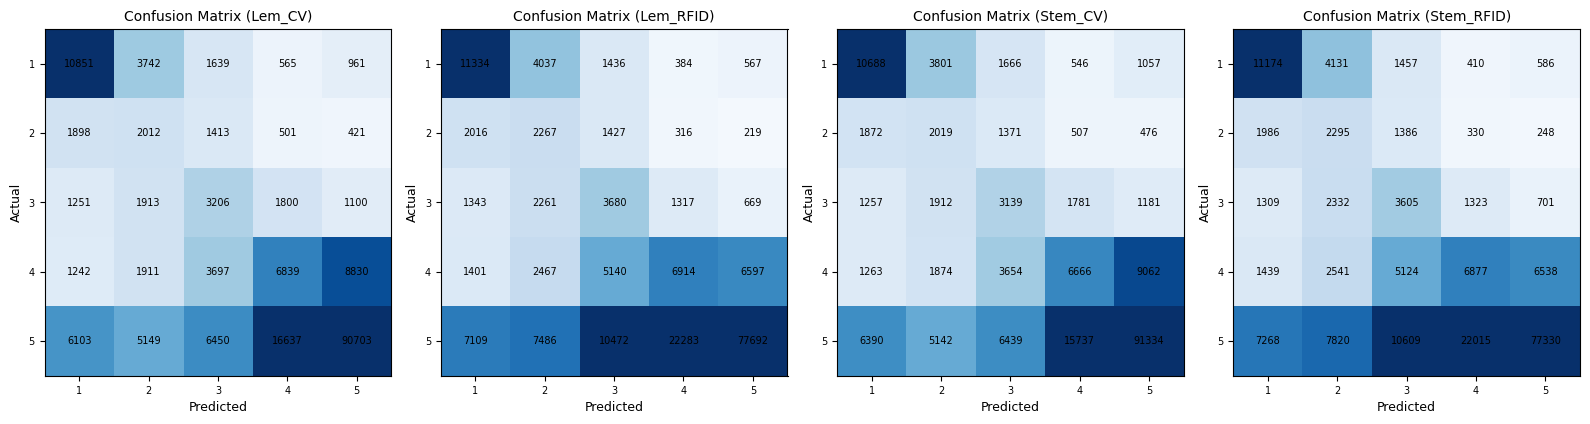

Lem_TFIDF: Train Accuracy - 0.5595, Test Accuracy - 0.5634
Lem_CV: Train Accuracy - 0.5411, Test Accuracy - 0.6283
Stem_TFIDF: Train Accuracy - 0.5408, Test Accuracy - 0.5601
Stem_CV: Train Accuracy - 0.5209, Test Accuracy - 0.6296


In [100]:
combinations = ['Lem_CV', 'Lem_RFID', 'Stem_CV', 'Stem_RFID']

plt.figure(figsize=(16, 4))

for i, combination in enumerate(combinations, 1):
    plt.subplot(1, 4, i)
    
    # Get y_test and y_pred_test for the current combination
    y_test_comb = globals()[f"y_test"]
    y_pred_test_comb = globals()[f"y_pred_test_nb_{combination.lower()}"]
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test_comb, y_pred_test_comb)

    print(cm)
    
    # Plotting Confusion Matrix using imshow
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 10000)
    
    # Adding annotations
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)
    
    plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
    plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
    plt.title(f'Confusion Matrix ({combination})', fontsize=10)
    plt.xlabel('Predicted', fontsize=9)
    plt.ylabel('Actual', fontsize=9)

plt.tight_layout()
# plt.savefig('../../images/NBUSConfMatrix.png')
plt.show()

accuracy_scores = {
    'Lem_CV': {'Train': accuracy_train_nb_lem_cv, 'Test': accuracy_test_nb_lem_cv},
    'Lem_TFIDF': {'Train': accuracy_train_nb_lem_rfid, 'Test': accuracy_test_nb_lem_rfid},
    'Stem_CV': {'Train': accuracy_train_nb_stem_cv, 'Test': accuracy_test_nb_stem_cv},
    'Stem_TFIDF': {'Train': accuracy_train_nb_stem_rfid, 'Test': accuracy_test_nb_stem_rfid},
}

# Sorting based on the test accuracy
sorted_accuracy_scores = sorted(accuracy_scores.items(), key=lambda x: x[1]['Train'], reverse=True)

# Displaying the sorted results
for combination, scores in sorted_accuracy_scores:
    print(f"{combination}: Train Accuracy - {scores['Train']:.4f}, Test Accuracy - {scores['Test']:.4f}")

### Best NB Model

In [23]:
accuracy_train_nb_best = accuracy_score(y_train, y_pred_train_nb_stem_cv)
precision_train_nb_best = precision_score(y_train, y_pred_train_nb_stem_cv, average='weighted')
recall_train_nb_best = recall_score(y_train, y_pred_train_nb_stem_cv, average='weighted')
f1_train_nb_best = f1_score(y_train, y_pred_train_nb_stem_cv, average='weighted')
r2_train_nb_best = r2_score(y_train, y_pred_train_nb_stem_cv)
mse_train_nb_best = mean_squared_error(y_train, y_pred_train_nb_stem_cv)

accuracy_test_nb_best = accuracy_score(y_test, y_pred_test_nb_stem_cv)
precision_test_nb_best = precision_score(y_test, y_pred_test_nb_stem_cv, average='weighted')
recall_test_nb_best = recall_score(y_test, y_pred_test_nb_stem_cv, average='weighted')
f1_test_nb_best = f1_score(y_test, y_pred_test_nb_stem_cv, average='weighted')
r2_test_nb_best = r2_score(y_test, y_pred_test_nb_stem_cv)
mse_test_nb_best = mean_squared_error(y_test, y_pred_test_nb_stem_cv)

print('Train Results')
print("Accuracy Score: Naive Bayes Classification Train Data (stem - CV):", accuracy_train_nb_best)
print("Precision Score: Naive Bayes Classification Train Data (stem - CV):", precision_train_nb_best)
print("Recall Score: Naive Bayes Classification Data (stem - CV):", recall_train_nb_best)
print("F1 Score: Naive Bayes Naive BayesClassification Train Data (stem - CV):", f1_train_nb_best)
print("R Squared Score: Naive Bayes Classification Train Data (stem - CV):", r2_train_nb_best)
print("Mean Squared Error Score: Naive Bayes Classification Train Data (stem - CV):", mse_train_nb_best)
print()
print('Test Results')
print("Accuracy Score: Naive Bayes Classification Test Data (stem - CV):", accuracy_test_nb_best)
print("Precision Score: Naive Bayes Classification Test Data (stem - CV):", precision_test_nb_best)
print("Recall Score: Naive Bayes Classification Test Data (stem - CV):", recall_test_nb_best)
print("F1 Score: Naive Bayes Classification Test Data (stem - CV):", f1_test_nb_best)
print("R Squared Score: Naive Bayes Classification Test Data (stem - CV):", r2_test_nb_best)
print("Mean Squared Error Score: Naive Bayes Classification Test Data (stem - CV):", mse_test_nb_best)

Train Results
Accuracy Score: Naive Bayes Classification Train Data (stem - CV): 0.5230864793981641
Precision Score: Naive Bayes Classification Train Data (stem - CV): 0.5167436852031647
Recall Score: Naive Bayes Classification Data (stem - CV): 0.5230864793981641
F1 Score: Naive Bayes Naive BayesClassification Train Data (stem - CV): 0.5141511510382334
R Squared Score: Naive Bayes Classification Train Data (stem - CV): 0.3111394851266478
Mean Squared Error Score: Naive Bayes Classification Train Data (stem - CV): 1.3777210297467044

Test Results
Accuracy Score: Naive Bayes Classification Test Data (stem - CV): 0.6243350254929936
Precision Score: Naive Bayes Classification Test Data (stem - CV): 0.710781758195993
Recall Score: Naive Bayes Classification Test Data (stem - CV): 0.6243350254929936
F1 Score: Naive Bayes Classification Test Data (stem - CV): 0.6585010877424236
R Squared Score: Naive Bayes Classification Test Data (stem - CV): 0.1109316556926595
Mean Squared Error Score: Nai

[[ 9059  2816  1337   489   788]
 [ 3474  6206  2750  1104   955]
 [ 1718  2437  6172  2370  1792]
 [  737  1018  1807  5427  5500]
 [  584   549   644  1681 11031]]
[[10384  4003  1769   579  1023]
 [ 1711  2121  1385   572   456]
 [ 1153  1933  3218  1812  1154]
 [ 1179  1888  3640  7017  8795]
 [ 5928  5305  6487 17161 90161]]


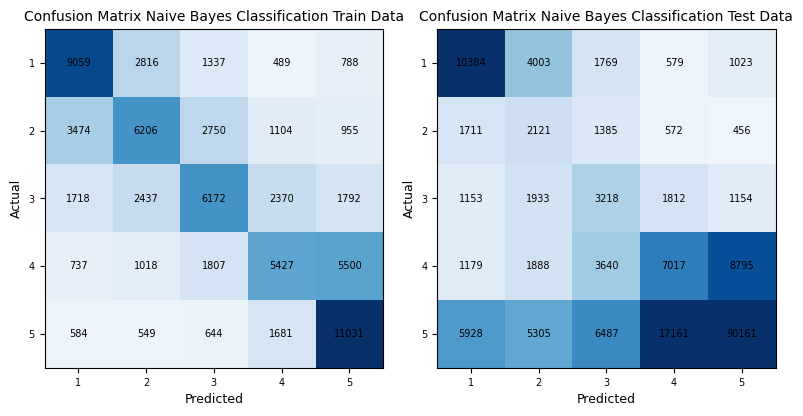

In [33]:
# Calculate confusion matrix
plt.figure(figsize=(8, 4))

# Calculate confusion matrix
cm = confusion_matrix(y_train, y_pred_train_nb_stem_cv)

print(cm)

# Plotting Confusion Matrix using imshow
plt.subplot(1, 2, 1)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 10000)

# Adding annotations
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)

plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.xlabel('Predicted', fontsize=9)
plt.ylabel('Actual', fontsize=9)
plt.title(f'Confusion Matrix Naive Bayes Classification Train Data', fontsize=10)

cm = confusion_matrix(y_test, y_pred_test_nb_stem_cv)

print(cm)
plt.subplot(1, 2, 2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 10000)

# Adding annotations
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)

plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.xlabel('Predicted', fontsize=9)
plt.ylabel('Actual', fontsize=9)

plt.title(f'Confusion Matrix Naive Bayes Classification Test Data', fontsize=10)
plt.tight_layout()
# plt.savefig('../../images/NBBestConfMatrix.png')
plt.show()

# 7. Gradient Boosting Classifier

In [54]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [55]:
# a) XGBoost on Lemmatized CountVectorized data

# XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_lem_CV_train, y_train_encoded)
y_pred_train_xgb_lem_cv = xgb_model.predict(X_lem_CV_train)
y_pred_test_xgb_lem_cv = xgb_model.predict(X_lem_CV_test)

# XGBoost classification reports and accuracy scores
xgb_report_train_lem_cv_imbalanced = classification_report_imbalanced(y_train, y_pred_train_xgb_lem_cv)
xgb_report_test_lem_cv_imbalanced = classification_report_imbalanced(y_test, y_pred_test_xgb_lem_cv)
accuracy_train_xgb_lem_cv = accuracy_score(y_train, y_pred_train_xgb_lem_cv)
accuracy_test_xgb_lem_cv = accuracy_score(y_test, y_pred_test_xgb_lem_cv)

# Print results
print("XGBoost - Classification Report: Train Data (lem_cv):\n", xgb_report_train_lem_cv_imbalanced)
print("\nXGBoost - Classification Report: Test Data (lem_cv):\n", xgb_report_test_lem_cv_imbalanced)
print("\nAccuracy Score: Train Data (lem_cv):", accuracy_train_xgb_lem_cv)
print("Accuracy Score: Test Data (lem_cv):", accuracy_test_xgb_lem_cv)

XGBoost - Classification Report: Train Data (lem_cv):
                    pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      0.79      0.00      0.00      0.00         0
          1       0.17      0.18      0.77      0.18      0.38      0.13     14489
          2       0.15      0.11      0.84      0.13      0.31      0.09     14489
          3       0.18      0.18      0.79      0.18      0.38      0.13     14489
          4       0.23      0.25      0.79      0.24      0.44      0.19     14489
          5       0.00      0.00      1.00      0.00      0.00      0.00     14489

avg / total       0.15      0.14      0.84      0.14      0.30      0.11     72445


XGBoost - Classification Report: Test Data (lem_cv):
                    pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      0.90      0.00      0.00      0.00         0
          1       0.21      0.26      0.90      0.24    

c:\Users\Scratticus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Scratticus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Scratticus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [56]:
# TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

print(X_lem_CV_train.shape)

# # Convert sparse matrix to dense array
# conversion_list = [
#     X_lem_CV_train, 
#     X_lem_CV_test, 
#     X_lem_RFID_train, 
#     X_lem_RFID_test, 
#     X_stem_CV_train, 
#     X_stem_CV_test, 
#     X_stem_RFID_train, 
#     X_stem_RFID_test
# ]

# string_list = [
#     'X_lem_CV_train', 
#     'X_lem_CV_test', 
#     'X_lem_RFID_train', 
#     'X_lem_RFID_test', 
#     'X_stem_CV_train', 
#     'X_stem_CV_test', 
#     'X_stem_RFID_train', 
#     'X_stem_RFID_test'
# ]

# dense_dict = {}

# for idx, data in enumerate(conversion_list):
#     data_rows = data.shape[0]
#     half = int(data_rows * 0.5)
#     data_1 = data[:half, :]
#     data_1_array = data_1.toarray()
#     data_2 = data[half:, :]
#     data_2_array = data_2.toarray()
#     data_array = np.concatenate(data_1_array, data_2_array)
#     dense_dict[string_list[idx]] = data_array

X_lem_CV_train_dense = X_lem_CV_train.toarray()
X_lem_CV_test_dense = X_lem_CV_test.toarray()
X_lem_RFID_train_dense = X_lem_RFID_train.toarray()
X_lem_RFID_test_dense = X_lem_RFID_test.toarray()
X_stem_CV_train_dense = X_stem_CV_train.toarray()
X_stem_CV_test_dense = X_stem_CV_test.toarray()
X_stem_RFID_train_dense = X_stem_RFID_train.toarray()
X_stem_RFID_test_dense = X_stem_RFID_test.toarray()

(72445, 26701)


MemoryError: Unable to allocate 36.0 GiB for an array with shape (180834, 26701) and data type int64

In [57]:
# a) HistGradientBoosting Classifier on Lemmatized CountVectorized data

# HistGradientBoosting model
hist_gb_model = HistGradientBoostingClassifier()  # You can customize parameters here if needed
hist_gb_model.fit(X_lem_CV_train_dense, y_train)
y_pred_train_hist_gb_lem_cv = hist_gb_model.predict(X_lem_CV_train_dense)
y_pred_test_hist_gb_lem_cv = hist_gb_model.predict(X_lem_CV_test_dense)

# HistGradientBoosting classification reports and accuracy scores
hist_gb_report_train_lem_cv_imbalanced = classification_report_imbalanced(y_train, y_pred_train_hist_gb_lem_cv)
hist_gb_report_test_lem_cv_imbalanced = classification_report_imbalanced(y_test, y_pred_test_hist_gb_lem_cv)
accuracy_train_hist_gb_lem_cv = accuracy_score(y_train, y_pred_train_hist_gb_lem_cv)
accuracy_test_hist_gb_lem_cv = accuracy_score(y_test, y_pred_test_hist_gb_lem_cv)

# Print results
print("HistGradientBoosting - Classification Report: Train Data (lem_cv):\n", hist_gb_report_train_lem_cv_imbalanced)
print("\nHistGradientBoosting - Classification Report: Test Data (lem_cv):\n", hist_gb_report_test_lem_cv_imbalanced)
print("\nAccuracy Score: Train Data (lem_cv):", accuracy_train_hist_gb_lem_cv)
print("Accuracy Score: Test Data (lem_cv):", accuracy_test_hist_gb_lem_cv)

HistGradientBoosting - Classification Report: Train Data (lem_cv):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.63      0.69      0.90      0.66      0.79      0.61     14489
          2       0.49      0.49      0.87      0.49      0.65      0.41     14489
          3       0.56      0.44      0.91      0.49      0.63      0.38     14489
          4       0.50      0.50      0.88      0.50      0.66      0.42     14489
          5       0.63      0.70      0.90      0.66      0.79      0.61     14489

avg / total       0.56      0.56      0.89      0.56      0.70      0.49     72445


HistGradientBoosting - Classification Report: Test Data (lem_cv):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.59      0.63      0.95      0.61      0.77      0.58     17758
          2       0.13      0.38      0.91      0.19      0.58      0.32      6245
          3       0.22      0.

In [58]:
# b) HistGradientBoosting Classifier on Lemmatized TFIDFVectorized data

# HistGradientBoosting model
hist_gb_model = HistGradientBoostingClassifier()  # You can customize parameters here if needed
hist_gb_model.fit(X_lem_RFID_train_dense, y_train)
y_pred_train_hist_gb_lem_rfid = hist_gb_model.predict(X_lem_RFID_train_dense)
y_pred_test_hist_gb_lem_rfid = hist_gb_model.predict(X_lem_RFID_test_dense)

# HistGradientBoosting classification reports and accuracy scores
hist_gb_report_train_lem_rfid_imbalanced = classification_report_imbalanced(y_train, y_pred_train_hist_gb_lem_rfid)
hist_gb_report_test_lem_rfid_imbalanced = classification_report_imbalanced(y_test, y_pred_test_hist_gb_lem_rfid)
accuracy_train_hist_gb_lem_rfid = accuracy_score(y_train, y_pred_train_hist_gb_lem_rfid)
accuracy_test_hist_gb_lem_rfid = accuracy_score(y_test, y_pred_test_hist_gb_lem_rfid)

# Print results
print("HistGradientBoosting - Classification Report: Train Data (lem_tfidf):\n", hist_gb_report_train_lem_rfid_imbalanced)
print("\nHistGradientBoosting - Classification Report: Test Data (lem_tfidf):\n", hist_gb_report_test_lem_rfid_imbalanced)
print("\nAccuracy Score: Train Data (lem_tfidf):", accuracy_train_hist_gb_lem_rfid)
print("Accuracy Score: Test Data (lem_tfidf):", accuracy_test_hist_gb_lem_rfid)

HistGradientBoosting - Classification Report: Train Data (lem_tfidf):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.64      0.70      0.90      0.67      0.80      0.62     14489
          2       0.51      0.53      0.87      0.52      0.68      0.44     14489
          3       0.58      0.47      0.91      0.52      0.66      0.41     14489
          4       0.54      0.51      0.89      0.52      0.67      0.44     14489
          5       0.65      0.71      0.91      0.68      0.80      0.63     14489

avg / total       0.58      0.58      0.90      0.58      0.72      0.51     72445


HistGradientBoosting - Classification Report: Test Data (lem_tfidf):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.58      0.63      0.95      0.60      0.77      0.58     17758
          2       0.12      0.38      0.90      0.19      0.59      0.33      6245
          3       0.21  

In [59]:
# c) HistGradientBoosting Classifier on Stemmatized CountVectorized data

# HistGradientBoosting model
hist_gb_model = HistGradientBoostingClassifier()  # You can customize parameters here if needed
hist_gb_model.fit(X_stem_CV_train_dense, y_train)
y_pred_train_hist_gb_stem_cv = hist_gb_model.predict(X_stem_CV_train_dense)
y_pred_test_hist_gb_stem_cv = hist_gb_model.predict(X_stem_CV_test_dense)

# HistGradientBoosting classification reports and accuracy scores
hist_gb_report_train_stem_cv_imbalanced = classification_report_imbalanced(y_train, y_pred_train_hist_gb_stem_cv)
hist_gb_report_test_stem_cv_imbalanced = classification_report_imbalanced(y_test, y_pred_test_hist_gb_stem_cv)
accuracy_train_hist_gb_stem_cv = accuracy_score(y_train, y_pred_train_hist_gb_stem_cv)
accuracy_test_hist_gb_stem_cv = accuracy_score(y_test, y_pred_test_hist_gb_stem_cv)

# Print results
print("HistGradientBoosting - Classification Report: Train Data (stem_cv):\n", hist_gb_report_train_stem_cv_imbalanced)
print("\nHistGradientBoosting - Classification Report: Test Data (stem_cv):\n", hist_gb_report_test_stem_cv_imbalanced)
print("\nAccuracy Score: Train Data (stem_cv):", accuracy_train_hist_gb_stem_cv)
print("Accuracy Score: Test Data (stem_cv):", accuracy_test_hist_gb_stem_cv)

HistGradientBoosting - Classification Report: Train Data (stem_cv):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.62      0.70      0.89      0.66      0.79      0.61     14489
          2       0.50      0.49      0.88      0.49      0.65      0.41     14489
          3       0.55      0.44      0.91      0.49      0.63      0.38     14489
          4       0.50      0.49      0.88      0.50      0.66      0.42     14489
          5       0.62      0.70      0.89      0.66      0.79      0.61     14489

avg / total       0.56      0.56      0.89      0.56      0.71      0.49     72445


HistGradientBoosting - Classification Report: Test Data (stem_cv):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.59      0.63      0.95      0.61      0.78      0.58     17758
          2       0.12      0.36      0.91      0.19      0.57      0.31      6245
          3       0.21      

In [60]:
# d) HistGradientBoosting Classifier on Stemmatized TFIDFVectorized data

# HistGradientBoosting model
hist_gb_model = HistGradientBoostingClassifier()  # You can customize parameters here if needed
hist_gb_model.fit(X_stem_RFID_train_dense, y_train)
y_pred_train_hist_gb_stem_rfid = hist_gb_model.predict(X_stem_RFID_train_dense)
y_pred_test_hist_gb_stem_rfid = hist_gb_model.predict(X_stem_RFID_test_dense)

# HistGradientBoosting classification reports and accuracy scores
hist_gb_report_train_stem_rfid_imbalanced = classification_report_imbalanced(y_train, y_pred_train_hist_gb_stem_rfid)
hist_gb_report_test_stem_rfid_imbalanced = classification_report_imbalanced(y_test, y_pred_test_hist_gb_stem_rfid)
accuracy_train_hist_gb_stem_rfid = accuracy_score(y_train, y_pred_train_hist_gb_stem_rfid)
accuracy_test_hist_gb_stem_rfid = accuracy_score(y_test, y_pred_test_hist_gb_stem_rfid)

# Print results
print("HistGradientBoosting - Classification Report: Train Data (stem_tfidf):\n", hist_gb_report_train_stem_rfid_imbalanced)
print("\nHistGradientBoosting - Classification Report: Test Data (stem_tfidf):\n", hist_gb_report_test_stem_rfid_imbalanced)
print("\nAccuracy Score: Train Data (stem_tfidf):", accuracy_train_hist_gb_stem_rfid)
print("Accuracy Score: Test Data (stem_tfidf):", accuracy_test_hist_gb_stem_rfid)

HistGradientBoosting - Classification Report: Train Data (stem_tfidf):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.63      0.71      0.90      0.67      0.80      0.62     14489
          2       0.52      0.52      0.88      0.52      0.68      0.44     14489
          3       0.58      0.48      0.91      0.52      0.66      0.42     14489
          4       0.54      0.51      0.89      0.52      0.67      0.43     14489
          5       0.65      0.71      0.90      0.68      0.80      0.63     14489

avg / total       0.58      0.59      0.90      0.58      0.72      0.51     72445


HistGradientBoosting - Classification Report: Test Data (stem_tfidf):
                    pre       rec       spe        f1       geo       iba       sup

          1       0.58      0.63      0.95      0.60      0.77      0.58     17758
          2       0.12      0.37      0.91      0.19      0.58      0.32      6245
          3       0.21

## Summary - Gradient Boosting

In [61]:
# a) Lemmatized CountVectorized data
hist_gb_report_train_lem_cv_imbalanced_last = [accuracy_train_hist_gb_lem_cv * 100] + [float(value) for value in hist_gb_report_train_lem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
hist_gb_report_test_lem_cv_imbalanced_last = [accuracy_test_hist_gb_lem_cv * 100] + [float(value) for value in hist_gb_report_test_lem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_hist_gb_report_lem_cv_imbalanced = pd.DataFrame([hist_gb_report_train_lem_cv_imbalanced_last, hist_gb_report_test_lem_cv_imbalanced_last], columns=column_names)
final_hist_gb_report_lem_cv_imbalanced['Data Type'] = ['Lemmatized Count Vectorized', 'Lemmatized Count Vectorized']
final_hist_gb_report_lem_cv_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_hist_gb_report_lem_cv_imbalanced.set_index('Data Type', inplace=True)
final_hist_gb_report_lem_cv_imbalanced.index.name = None

# Reorder columns
final_hist_gb_report_lem_cv_imbalanced = final_hist_gb_report_lem_cv_imbalanced[['Train/Test'] + column_names]

# b) Lemmatized TFIDFVectorized data
hist_gb_report_train_lem_rfid_imbalanced_last = [accuracy_train_hist_gb_lem_rfid * 100] + [float(value) for value in hist_gb_report_train_lem_rfid_imbalanced.split()[-7:]]  # Extracting the last 6 values
hist_gb_report_test_lem_rfid_imbalanced_last = [accuracy_test_hist_gb_lem_rfid * 100] + [float(value) for value in hist_gb_report_test_lem_rfid_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_hist_gb_report_lem_rfid_imbalanced = pd.DataFrame([hist_gb_report_train_lem_rfid_imbalanced_last, hist_gb_report_test_lem_rfid_imbalanced_last], columns=column_names)
final_hist_gb_report_lem_rfid_imbalanced['Data Type'] = ['Lemmatized TFIDF Vectorized', 'Lemmatized TFIDF Vectorized']
final_hist_gb_report_lem_rfid_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_hist_gb_report_lem_rfid_imbalanced.set_index('Data Type', inplace=True)
final_hist_gb_report_lem_rfid_imbalanced.index.name = None

# Reorder columns
final_hist_gb_report_lem_rfid_imbalanced = final_hist_gb_report_lem_rfid_imbalanced[['Train/Test'] + column_names]

# c) Stemmatized CountVectorized data
hist_gb_report_train_stem_cv_imbalanced_last = [accuracy_train_hist_gb_stem_cv * 100] + [float(value) for value in hist_gb_report_train_stem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
hist_gb_report_test_stem_cv_imbalanced_last = [accuracy_test_hist_gb_stem_cv * 100] + [float(value) for value in hist_gb_report_test_stem_cv_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_hist_gb_report_stem_cv_imbalanced = pd.DataFrame([hist_gb_report_train_stem_cv_imbalanced_last, hist_gb_report_test_stem_cv_imbalanced_last], columns=column_names)
final_hist_gb_report_stem_cv_imbalanced['Data Type'] = ['Stemmatized Count Vectorized', 'Stemmatized Count Vectorized']
final_hist_gb_report_stem_cv_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_hist_gb_report_stem_cv_imbalanced.set_index('Data Type', inplace=True)
final_hist_gb_report_stem_cv_imbalanced.index.name = None

# Reorder columns
final_hist_gb_report_stem_cv_imbalanced = final_hist_gb_report_stem_cv_imbalanced[['Train/Test'] + column_names]

# d) Stemmatized TFIDFVectorized data
hist_gb_report_train_stem_rfid_imbalanced_last = [accuracy_train_hist_gb_stem_rfid * 100] + [float(value) for value in hist_gb_report_train_stem_rfid_imbalanced.split()[-7:]]  # Extracting the last 6 values
hist_gb_report_test_stem_rfid_imbalanced_last = [accuracy_test_hist_gb_stem_rfid * 100] + [float(value) for value in hist_gb_report_test_stem_rfid_imbalanced.split()[-7:]]  # Extracting the last 6 values
column_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'Geometric Mean', 'Index Balanced Accuracy (IBA)', 'Support']
final_hist_gb_report_stem_rfid_imbalanced = pd.DataFrame([hist_gb_report_train_stem_rfid_imbalanced_last, hist_gb_report_test_stem_rfid_imbalanced_last], columns=column_names)
final_hist_gb_report_stem_rfid_imbalanced['Data Type'] = ['Stemmatized TFIDF Vectorized', 'Stemmatized TFIDF Vectorized']
final_hist_gb_report_stem_rfid_imbalanced['Train/Test'] = ['Train', 'Test']

# Set 'Data Type' column as the index and drop the index column
final_hist_gb_report_stem_rfid_imbalanced.set_index('Data Type', inplace=True)
final_hist_gb_report_stem_rfid_imbalanced.index.name = None

# Reorder columns
final_hist_gb_report_stem_rfid_imbalanced = final_hist_gb_report_stem_rfid_imbalanced[['Train/Test'] + column_names]


### Averaged classification report for Histogram Gradient Boosting Classifier

In [62]:
final_hist_gb_report = pd.concat([final_hist_gb_report_lem_cv_imbalanced,
                    final_hist_gb_report_lem_rfid_imbalanced,
                    final_hist_gb_report_stem_cv_imbalanced,
                    final_hist_gb_report_stem_rfid_imbalanced])

final_hist_gb_report.head(8)

,Train/Test,Accuracy,Precision,Recall,Specificity,F1-Score,Geometric Mean,Index Balanced Accuracy (IBA),Support
Lemmatized Count Vectorized,Train,56.300642,0.56,0.56,0.89,0.56,0.70,0.49,72445.0
Lemmatized Count Vectorized,Test,60.045677,0.73,0.60,0.86,0.65,0.72,0.50,180834.0
Lemmatized TFIDF Vectorized,Train,58.418110,0.58,0.58,0.90,0.58,0.72,0.51,72445.0
Lemmatized TFIDF Vectorized,Test,59.718858,0.73,0.60,0.87,0.65,0.72,0.50,180834.0
Stemmatized Count Vectorized,Train,56.357237,0.56,0.56,0.89,0.56,0.71,0.49,72445.0
Stemmatized Count Vectorized,Test,60.044018,0.73,0.60,0.86,0.65,0.72,0.51,180834.0
Stemmatized TFIDF Vectorized,Train,58.601698,0.58,0.59,0.90,0.58,0.72,0.51,72445.0
Stemmatized TFIDF Vectorized,Test,59.548536,0.73,0.60,0.87,0.64,0.71,0.50,180834.0


### Confusion Matrix for Histogram Gradient Boosting

[[11139  4051  1222   826   520]
 [ 1864  2344  1162   569   306]
 [ 1088  2074  3208  2078   822]
 [  881  2165  3268  9516  6689]
 [ 3957  7880  5535 25294 82376]]
[[11118  4142  1266   751   481]
 [ 1909  2376  1165   526   269]
 [ 1063  2234  3283  1956   734]
 [  934  2262  3551  9267  6505]
 [ 4113  8058  6055 24868 81948]]
[[11218  3950  1207   836   547]
 [ 1879  2267  1213   566   320]
 [ 1101  2079  3248  2039   803]
 [  902  2172  3350  9461  6634]
 [ 3999  7670  6132 24855 82386]]
[[11182  4066  1229   772   509]
 [ 1923  2307  1213   527   275]
 [ 1108  2159  3355  1869   779]
 [  924  2293  3620  9177  6505]
 [ 4082  7857  6223 25217 81663]]


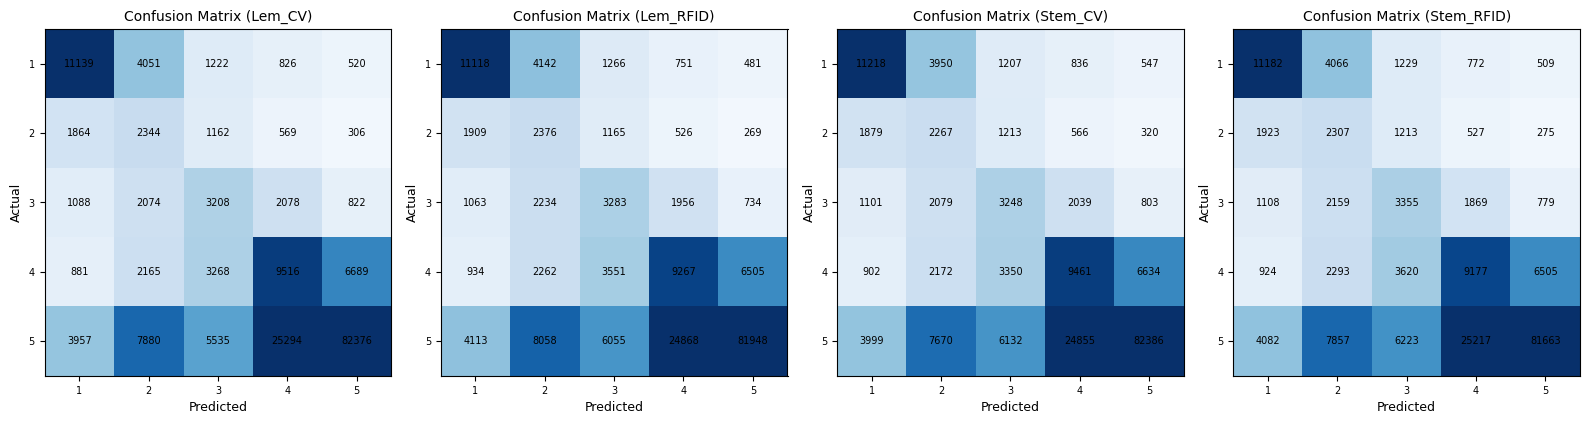

Stem_TFIDF: Train Accuracy - 0.5860, Test Accuracy - 0.5955
Lem_TFIDF: Train Accuracy - 0.5842, Test Accuracy - 0.5972
Stem_CV: Train Accuracy - 0.5636, Test Accuracy - 0.6004
Lem_CV: Train Accuracy - 0.5630, Test Accuracy - 0.6005


In [99]:
combinations = ['Lem_CV', 'Lem_RFID', 'Stem_CV', 'Stem_RFID']

plt.figure(figsize=(16, 4))

for i, combination in enumerate(combinations, 1):
    plt.subplot(1, 4, i)
    
    # Get y_test and y_pred_test for the current combination
    y_test_comb = globals()[f"y_test"]
    y_pred_test_comb = globals()[f"y_pred_test_hist_gb_{combination.lower()}"]
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test_comb, y_pred_test_comb)

    print(cm)
    
    # Plotting Confusion Matrix using imshow
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 10000)
    
    # Adding annotations
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)
    
    plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
    plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
    plt.title(f'Confusion Matrix ({combination})', fontsize=10)
    plt.xlabel('Predicted', fontsize=9)
    plt.ylabel('Actual', fontsize=9)

plt.tight_layout()
# plt.savefig('../../images/HGBCUSConfMatrix.png')
plt.show()

accuracy_scores = {
    'Lem_CV': {'Train': accuracy_train_hist_gb_lem_cv, 'Test': accuracy_test_hist_gb_lem_cv},
    'Lem_TFIDF': {'Train': accuracy_train_hist_gb_lem_rfid, 'Test': accuracy_test_hist_gb_lem_rfid},
    'Stem_CV': {'Train': accuracy_train_hist_gb_stem_cv, 'Test': accuracy_test_hist_gb_stem_cv},
    'Stem_TFIDF': {'Train': accuracy_train_hist_gb_stem_rfid, 'Test': accuracy_test_hist_gb_stem_rfid},
}

# Sorting based on the test accuracy
sorted_accuracy_scores = sorted(accuracy_scores.items(), key=lambda x: x[1]['Train'], reverse=True)

# Displaying the sorted results
for combination, scores in sorted_accuracy_scores:
    print(f"{combination}: Train Accuracy - {scores['Train']:.4f}, Test Accuracy - {scores['Test']:.4f}")

### Best HGBC Model

In [24]:
# Best HGBC Model

# Best results achieved without Sampling
best_hgbc_train_tokens = column_stemmatizer(X_train_nosample)
best_hgbc_test_tokens = column_stemmatizer(X_test)

best_hgbc_train_vectors, best_hgbc_test_vectors = count_vectorize_data(best_hgbc_train_tokens, best_hgbc_test_tokens)

best_hgbc_train_dense = best_hgbc_train_vectors.toarray()
best_hgbc_test_dense = best_hgbc_test_vectors.toarray()

scaler = MaxAbsScaler()
best_hgbc_train_scaled = scaler.fit_transform(best_hgbc_train_dense)
best_hgbc_test_scaled = scaler.transform(best_hgbc_test_dense)

print('preprocessing complete')

best_hgbc_model = HistGradientBoostingClassifier(learning_rate=0.5, max_depth=None)
best_hgbc_model.fit(best_hgbc_train_scaled, y_train_nosample)

print('model fitted')

y_pred_train_hgbc_best = best_rf_model.predict(best_hgbc_train_scaled)
print('train predicted')

y_pred_test_hgbc_best = best_rf_model.predict(best_hgbc_test_scaled)
print('test predicted')

accuracy_train_hgbc_best = accuracy_score(y_train_nosample, y_pred_train_hgbc_best)
precision_train_hgbc_best = precision_score(y_train_nosample, y_pred_train_hgbc_best, average='weighted')
recall_train_hgbc_best = recall_score(y_train_nosample, y_pred_train_hgbc_best, average='weighted')
f1_train_hgbc_best = f1_score(y_train_nosample, y_pred_train_hgbc_best, average='weighted')
r2_train_hgbc_best = r2_score(y_train_nosample, y_pred_train_hgbc_best)
mse_train_hgbc_best = mean_squared_error(y_train_nosample, y_pred_train_hgbc_best)

accuracy_test_hgbc_best = accuracy_score(y_test, y_pred_test_hgbc_best)
precision_test_hgbc_best = precision_score(y_test, y_pred_test_hgbc_best, average='weighted')
recall_test_hgbc_best = recall_score(y_test, y_pred_test_hgbc_best, average='weighted')
f1_test_hgbc_best = f1_score(y_test, y_pred_test_hgbc_best, average='weighted')
r2_test_hgbc_best = r2_score(y_test, y_pred_test_hgbc_best)
mse_test_hgbc_best = mean_squared_error(y_test, y_pred_test_hgbc_best)

print('Train Results')
print("Accuracy Score: Random Forest Classification Train Data (lem - CV):", accuracy_train_hgbc_best)
print("Precision Score: Random Forest Classification Train Data (lem - CV):", precision_train_hgbc_best)
print("Recall Score: Random Forest Classification Train Data (lem - CV):", recall_train_hgbc_best)
print("F1 Score: Random Forest Classification Train Data (lem - CV):", f1_train_hgbc_best)
print("R Squared Score: Random Forest Classification Train Data (lem - CV):", r2_train_hgbc_best)
print("Mean Squared Error Score: Random Forest Classification Train Data (lem - CV):", mse_train_hgbc_best)
print()
print('Test Results')
print("Accuracy Score: Random Forest Classification Test Data (lem - CV):", accuracy_test_hgbc_best)
print("Precision Score: Random Forest Classification Test Data (lem - CV):", precision_test_hgbc_best)
print("Recall Score: Random Forest Classification Test Data (lem - CV):", recall_test_hgbc_best)
print("F1 Score: Random Forest Classification Test Data (lem - CV):", f1_test_hgbc_best)
print("R Squared Score: Random Forest Classification Test Data (lem - CV):", r2_test_hgbc_best)
print("Mean Squared Error Score: Random Forest Classification Test Data (lem - CV):", mse_test_hgbc_best)


MemoryError: Unable to allocate 132. GiB for an array with shape (421943, 41958) and data type float64

In [ ]:
# Calculate confusion matrix
plt.figure(figsize=(8, 4))

# Calculate confusion matrix
cm = confusion_matrix(y_train_nosample, y_pred_train_hgbc_best)

print(cm)

# Plotting Confusion Matrix using imshow
plt.subplot(1, 2, 1)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 3000)

# Adding annotations
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)

plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.xlabel('Predicted', fontsize=9)
plt.ylabel('Actual', fontsize=9)
plt.title(f'Confusion Matrix HGBC Classification Train Data', fontsize=10)

cm = confusion_matrix(y_test, y_pred_test_hgbc_best)

print(cm)
plt.subplot(1, 2, 2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin = 0, vmax = 3000)

# Adding annotations
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=7)

plt.xticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.yticks(np.arange(5), ['1', '2', '3', '4', '5'], fontsize=7)
plt.xlabel('Predicted', fontsize=9)
plt.ylabel('Actual', fontsize=9)

plt.title(f'Confusion Matrix HGBC Classification Test Data', fontsize=10)
plt.tight_layout()
# plt.savefig('../images/HGBCBestConfMatrix.png')
plt.show()

# ---------